In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde #Para distribucion estadistica de los datos en histograma
import scipy.stats as stats #para qqnorm y qqline o histograma Normal Q-Q plot
import statsmodels.api as sm #para el periodo de retorno
from statsmodels.formula.api import ols #ANOVA
from scipy import stats #ANOVA
import seaborn as sns #5.5 Tendencia de los caudales a lo largo del tiempo.
from sklearn.linear_model import LinearRegression #5.5 Tendencia de los caudales a lo largo del tiempo.

# 1. CARGA DEL FICHERO DE DATOS
file_path = "./DatosCaudalesBesos.csv"  # Cambia esto por la ruta de tu archivo si es diferente
TotalDat = pd.read_csv(file_path, encoding='latin1')

# 2. Inspección de los datos
print(TotalDat.info())     # Estructura de los datos
print(TotalDat.head())     # Ver las primeras filas
print(TotalDat.columns)    # Ver los nombres de las variables

# 3. Modificación de los tipos de datos y creación de nuevas variables
TotalDat['Estacio'] = TotalDat['Estacio'].astype('category')  # Convertir 'Estacio' a categoría
print(TotalDat['Estacio'].unique())  # Ver los valores únicos de la variable 'Estacio'

# 3.1 Renombrar con nombres cortos las estaciones de aforo y medida
# Nombres actuales
print(TotalDat['Estacio'].cat.categories)

# Definir los nuevos nombres cortos
nuevos_nombres = {
    'Aforament - Castellar del Vallès': "Castellar",
    'Aforament - Aiguafreda (riu)': "Aiguafreda",
    'Aforament - Montornès del Vallès (el Mogent)': "Montornes",
    'Aforament - Santa Perpètua de Mogoda': "Santa_Perpetua",
    'Aforament - Santa Coloma de Gramenet (riu)': "Santa_Coloma",
    'Aforament - Lliçà de Vall': "Llica_de_Vall",
    'Aforament - Montcada i Reixac (el Ripoll)': "Montcada_Reixac",
    'Aforament - la Garriga': "La_Garriga"
}

# Asignar los nuevos nombres
TotalDat['Estacio'] = TotalDat['Estacio'].replace(nuevos_nombres)
print(TotalDat.head())

# 3.2 Asegurarse de que la columna 'Dia' esté en formato de fecha
TotalDat['Fecha'] = pd.to_datetime(TotalDat['Dia'], format="%m/%d/%Y")

# Extraer el año correctamente ahora que la columna 'Fecha' está en el formato correcto
TotalDat['Year'] = TotalDat['Fecha'].dt.year

# Verificar si se creó la columna 'Year'
print(TotalDat.head())

# 3.3 Creación de nuevas variables (mes, año)
TotalDat['Mes'] = TotalDat['Fecha'].dt.month  # Extraer el mes
TotalDat['Year'] = TotalDat['Fecha'].dt.year  # Extraer el año

# 3.4 Mostrar las primeras filas para revisar las nuevas variables
print(TotalDat.head())

# 4. Cuántos datos tiene cada estación
print(TotalDat['Estacio'].value_counts())

# 5 Detección y eliminación de datos duplicados
DF_Montornes = TotalDat[TotalDat['Estacio'] == "Montornes"]

# Ordenar el dataframe por la columna 'Fecha'
DF_Montornes = DF_Montornes.sort_values(by='Fecha')
print(DF_Montornes.head())

# Eliminar las filas duplicadas
TotalDat = TotalDat.drop_duplicates()

# ORDENAR LAS ESTACIONES en el orden deseado
estaciones_ordenadas = ['Llica_de_Vall', 'Santa_Perpetua', 'Montornes', 
                        'Aiguafreda', 'La_Garriga', 'Montcada_Reixac', 
                        'Santa_Coloma', 'Castellar']
TotalDat['Estacio'] = pd.Categorical(TotalDat['Estacio'], categories=estaciones_ordenadas, ordered=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24952 entries, 0 to 24951
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Dia      24952 non-null  object 
 1   Estacio  24952 non-null  object 
 2   Valor    24842 non-null  float64
dtypes: float64(1), object(2)
memory usage: 584.9+ KB
None
         Dia                           Estacio  Valor
0  7/29/2000  Aforament - Castellar del Vallès   2.06
1  7/30/2000  Aforament - Castellar del Vallès   2.00
2  7/31/2000  Aforament - Castellar del Vallès   1.96
3   8/1/2000  Aforament - Castellar del Vallès   1.64
4   8/2/2000  Aforament - Castellar del Vallès   1.52
Index(['Dia', 'Estacio', 'Valor'], dtype='object')
['Aforament - Castellar del Vallès', 'Aforament - Aiguafreda (riu)', 'Aforament - Montornès del Vallès (el Mogent)', 'Aforament - Santa Perpètua de Mogoda', 'Aforament - Santa Coloma de Gramenet (riu)', 'Aforament - Lliçà de Vall', 'Aforament - Montcada i Reixac (el R

In [138]:
# Ver la tabla de frecuencia para la variable 'Estacio'
print(TotalDat['Estacio'].value_counts())

Estacio
Montcada_Reixac    3648
Llica_de_Vall      3646
Santa_Perpetua     3604
Montornes          3047
Santa_Coloma       2692
Castellar          2577
Aiguafreda         1493
La_Garriga         1198
Name: count, dtype: int64


In [139]:
import folium

# Coordenadas de las estaciones
estaciones = {
    "Castellar": [41.6156, 2.0873],
    "Aiguafreda": [41.7811, 2.2483],
    "Montornes": [41.5472, 2.2781],
    "Santa_Perpetua": [41.5325, 2.1806],
    "Santa_Coloma": [41.4515, 2.2063],
    "Llica_de_Vall": [41.5801, 2.2197],
    "Montcada_Reixac": [41.4821, 2.1924],
    "La_Garriga": [41.6848, 2.2886]
}

# Crear el mapa centrado en la región de las estaciones
m = folium.Map(location=[41.6, 2.2], zoom_start=11)

# Añadir las estaciones al mapa
for estacion, coord in estaciones.items():
    folium.Marker(location=coord, popup=estacion).add_to(m)

# Mostrar el mapa
m.save("mapa_estaciones.html")

In [140]:
# 6. Contar el número de datos por estación y por año
tabla_contingencia = TotalDat.groupby(['Estacio', 'Year']).size().reset_index(name='Count')

# Crear el gráfico interactivo con Plotly
fig = px.bar(tabla_contingencia, x='Year', y='Count', color='Estacio', 
             title="Número de datos para cada estación por año", 
             labels={"Count": "Número de Datos", "Year": "Año", "Estacio": "Estación"},
             barmode='group',  # Puedes usar 'stack' para barras apiladas o 'group' para barras agrupadas
             text='Count', hover_name="Estacio")

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Año",
    yaxis_title="Número de Datos",
    legend_title="Estaciones",
    bargap=0.2,
    hovermode="x unified"
)

# Mostrar el gráfico interactivo
fig.show()

In [128]:
# 1. Calcular el caudal medio anual para cada estación por año
caudal_medio_anual = TotalDat.groupby(['Estacio', 'Year']).agg({'Valor': 'mean'}).reset_index()

# 2. Crear el gráfico de barras interactivo con Plotly
fig = px.bar(caudal_medio_anual, x='Year', y='Valor', color='Estacio', 
             title="Caudal Medio Anual por Estación", 
             labels={"Valor": "Caudal Medio (m³/s)", "Year": "Año", "Estacio": "Estación"},
             barmode='group',  # Puedes cambiar a 'stack' si prefieres barras apiladas
             text='Valor', hover_name="Estacio")

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Año",
    yaxis_title="Caudal Medio Anual (m³/s)",
    legend_title="Estaciones",
    bargap=0.15,  # Espacio entre las barras
    hovermode="x unified"
)

# Mostrar el gráfico interactivo
fig.show()

In [141]:
# 5. Crear el gráfico de bigotes (boxplot) con Plotly
fig = px.box(TotalDat, x='Estacio', y='Valor', 
             title="Distribución de Caudales por Estación", 
             labels={"Valor": "Caudal (m³/s)", "Estacio": "Estación"},
             points="all")  # 'points="all"' añade todos los puntos atípicos en el gráfico

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Estación",
    yaxis_title="Caudal (m³/s)",
    boxmode='group',  # Agrupar las cajas por estación
)

# Mostrar el gráfico interactivo
fig.show()

In [149]:
#8.	¿Por encima de que caudal están el 25% de los caudales más elévalos en la estación de La Garriga?

# 4. Selección de la estación
# Cambia "La_Garriga" por la estación que deseas analizar
nombre_estacion = "La_Garriga"

# Filtrar los datos para la estación seleccionada
estacion_dat = TotalDat[TotalDat['Estacio'] == nombre_estacion]

# 5. Cálculo de los principales estadísticos para la estación seleccionada
media_estacion = estacion_dat['Valor'].mean(skipna=True)
mediana_estacion = estacion_dat['Valor'].median(skipna=True)
min_estacion = estacion_dat['Valor'].min(skipna=True)
max_estacion = estacion_dat['Valor'].max(skipna=True)

# Cálculo de los cuartiles (Q1 y Q3)
quantil_25_estacion = estacion_dat['Valor'].quantile(0.25, interpolation='linear')  # Q1
quantil_75_estacion = estacion_dat['Valor'].quantile(0.75, interpolation='linear')  # Q3
sd_estacion = estacion_dat['Valor'].std(skipna=True)

# 6. Imprimir los resultados
print(f"Estadísticos para la estación {nombre_estacion}:")
print("Media de caudales:", media_estacion)
print("Mediana de caudales:", mediana_estacion)
print("Mínimo de caudales:", min_estacion)
print("Máximo de caudales:", max_estacion)
print("Cuartil 25% de caudales (Q1):", quantil_25_estacion)
print("Cuartil 75% de caudales (Q3):", quantil_75_estacion)
print("Desviación estándar de caudales:", sd_estacion)

# 7. Calcular el caudal por encima del cual están el 25% de los caudales más elevados (Q3)
print(f"El caudal por encima del cual están el 25% de los caudales más elevados en la estación {nombre_estacion} es {quantil_75_estacion:.2f} m³/s")



Estadísticos para la estación La_Garriga:
Media de caudales: 0.2680217028380634
Mediana de caudales: 0.07
Mínimo de caudales: 0.0
Máximo de caudales: 9.62
Cuartil 25% de caudales (Q1): 0.05
Cuartil 75% de caudales (Q3): 0.22
Desviación estándar de caudales: 0.5763915720299931
El caudal por encima del cual están el 25% de los caudales más elevados en la estación La_Garriga es 0.22 m³/s


In [153]:
#Desviación estandart de todas las estaciones
# 1. Cálculo de la desviación estándar para cada estación
desviacion_estandar_por_estacion = TotalDat.groupby('Estacio')['Valor'].std().reset_index()

# 2. Renombrar las columnas para mayor claridad
desviacion_estandar_por_estacion.columns = ['Estacion', 'DesviacionEstandar']

# 3. Mostrar la tabla con la desviación estándar de cada estación
print(desviacion_estandar_por_estacion)


          Estacion  DesviacionEstandar
0    Llica_de_Vall            0.688093
1   Santa_Perpetua            0.821109
2        Montornes            0.513917
3       Aiguafreda            5.155915
4       La_Garriga            0.576392
5  Montcada_Reixac            1.133643
6     Santa_Coloma            4.415241
7        Castellar            2.540841


<Figure size 1000x600 with 0 Axes>

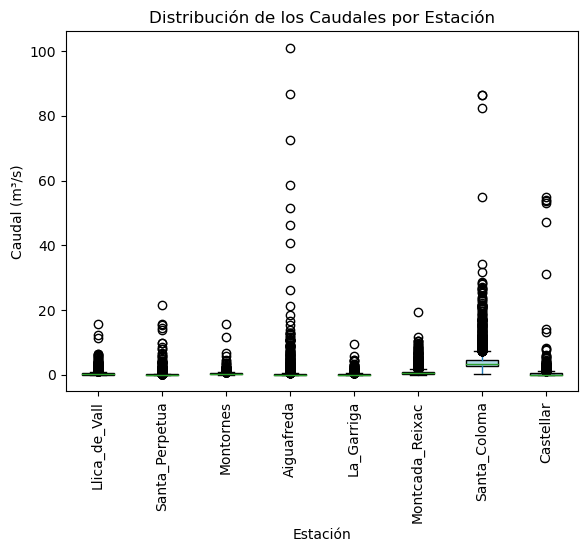

<Figure size 1000x600 with 0 Axes>

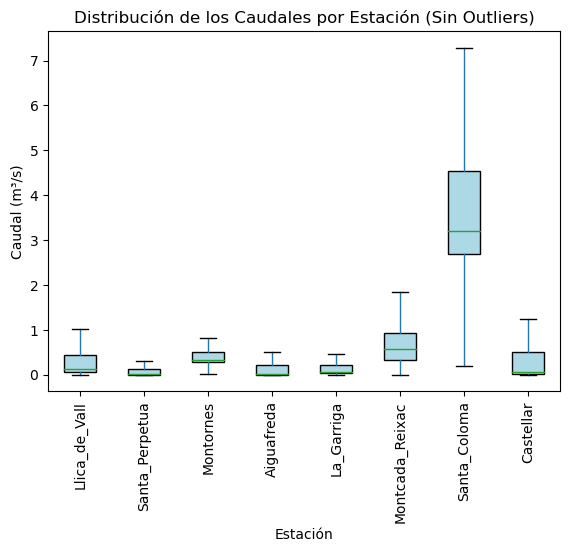

In [133]:
# Calcular la desviación estándar (variabilidad) por estación
variabilidad = TotalDat.groupby('Estacio')['Valor'].std()

# Graficar la distribución de los caudales por estación (Boxplot con outliers)
plt.figure(figsize=(10, 6))
TotalDat.boxplot(column='Valor', by='Estacio', grid=False, showfliers=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Distribución de los Caudales por Estación")
plt.suptitle("")
plt.xlabel("Estación")
plt.xticks(rotation=90)
plt.ylabel("Caudal (m³/s)")
plt.show()

# Graficar la distribución de los caudales por estación (Boxplot sin outliers)
plt.figure(figsize=(10, 6))
TotalDat.boxplot(column='Valor', by='Estacio', grid=False, showfliers=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Distribución de los Caudales por Estación (Sin Outliers)")
plt.suptitle("")
plt.xlabel("Estación")
plt.xticks(rotation=90)
plt.ylabel("Caudal (m³/s)")
plt.show()


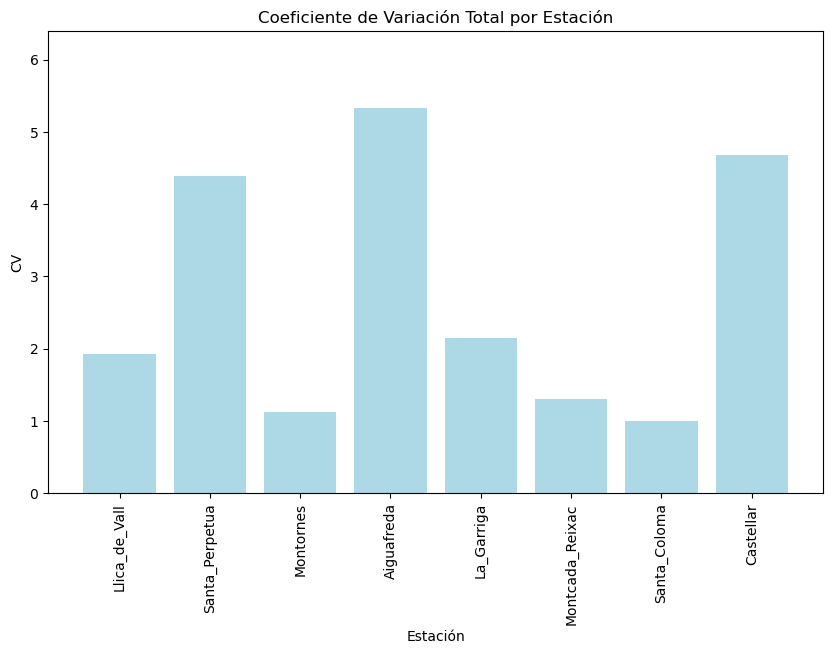

In [55]:
# Definir la función para el coeficiente de variación (CV)
def calc_cv(x):
    return x.std() / x.mean()

# Calcular el coeficiente de variación por estación
cv = TotalDat.groupby('Estacio')['Valor'].apply(calc_cv).reset_index(name='CV')

# Graficar el coeficiente de variación
plt.figure(figsize=(10, 6))
plt.bar(cv['Estacio'], cv['CV'], color="lightblue")
plt.title("Coeficiente de Variación Total por Estación")
plt.xlabel("Estación")
plt.ylabel("CV")
plt.xticks(rotation=90)
plt.ylim(0, max(cv['CV']) * 1.2)  # Ajustar el rango Y para visualizar mejor
plt.show()


<Figure size 1000x600 with 0 Axes>

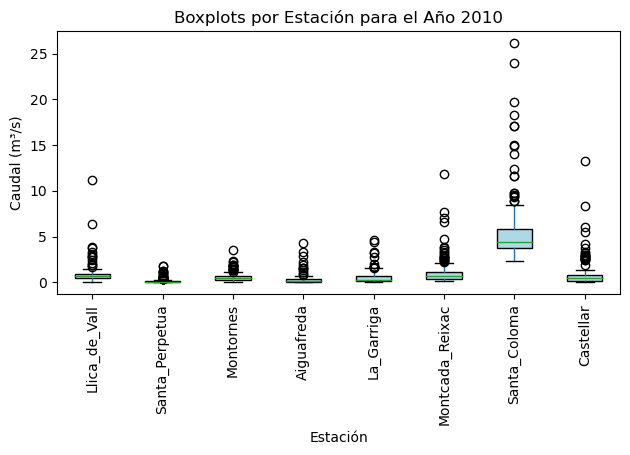

In [56]:
# 2. Crear un subconjunto para el año 2010
datos_Year_2010 = TotalDat[TotalDat['Year'] == 2010]

# 3. Crear un gráfico de boxplots para cada estación en el año 2010
plt.figure(figsize=(10, 6))

# Graficar el boxplot para cada estación
datos_Year_2010.boxplot(column='Valor', by='Estacio', grid=False, showfliers=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))

# Añadir título y etiquetas
plt.title("Boxplots por Estación para el Año 2010")
plt.suptitle('')  # Eliminar el título automático generado por matplotlib
plt.xlabel("Estación")
plt.ylabel("Caudal (m³/s)")
plt.xticks(rotation=90)  # Rotar los nombres de las estaciones si son largos
plt.tight_layout()

# Mostrar el gráfico
plt.show()



In [57]:
# 2. Crear un subconjunto para el año 2010
datos_Year_2010 = TotalDat[TotalDat['Year'] == 2010]

# 3. Crear un gráfico de boxplots para cada estación en el año 2010 usando Plotly
fig = px.box(datos_Year_2010, x='Estacio', y='Valor', 
             title='Boxplots por Estación para el Año 2010',
             labels={'Estacio': 'Estación', 'Valor': 'Caudal (m³/s)'},
             points='all'  # Mostrar todos los puntos atípicos (outliers)
            )

# Mostrar la gráfica interactiva
fig.show()

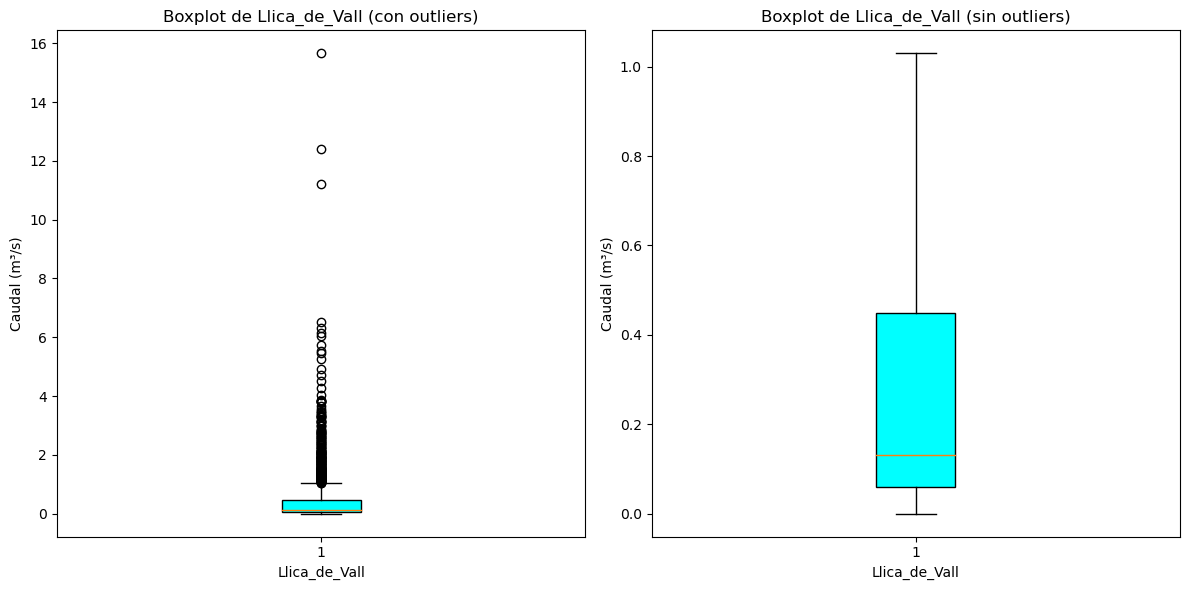

In [58]:
# 2. Seleccionar la estación
nombreST = "Llica_de_Vall"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Dibujar dos gráficos de boxplot, uno con outliers y otro sin outliers
plt.figure(figsize=(12, 6))

# Subplot 1: Con valores atípicos (outliers)
plt.subplot(1, 2, 1)
plt.boxplot(DF_St['Valor'], patch_artist=True, boxprops=dict(facecolor='cyan'))
plt.title(f"Boxplot de {nombreST} (con outliers)")
plt.xlabel(nombreST)
plt.ylabel("Caudal (m³/s)")

# Subplot 2: Sin valores atípicos (outliers)
plt.subplot(1, 2, 2)
plt.boxplot(DF_St['Valor'], patch_artist=True, boxprops=dict(facecolor='cyan'), showfliers=False)
plt.title(f"Boxplot de {nombreST} (sin outliers)")
plt.xlabel(nombreST)
plt.ylabel("Caudal (m³/s)")

# Ajustar el diseño para que no se sobrepongan los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

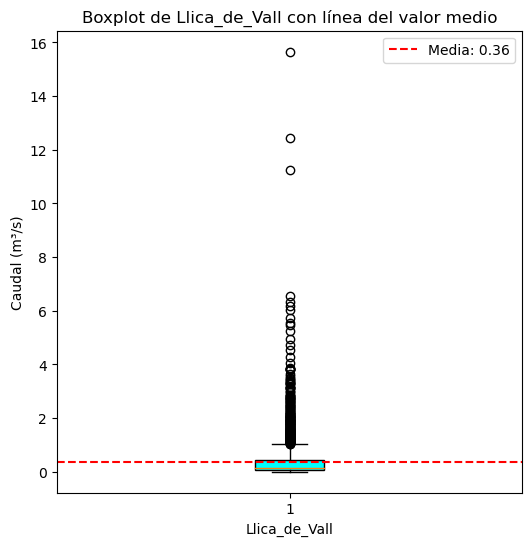

In [59]:
# 2. Seleccionar la estación
nombreST = "Llica_de_Vall"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Calcular el valor medio del caudal para esa estación, ignorando valores nulos
media_valor = DF_St['Valor'].mean(skipna=True)

# 4. Dibujar el boxplot y añadir la línea del valor medio
plt.figure(figsize=(6, 6))

# Boxplot con valores atípicos
plt.boxplot(DF_St['Valor'].dropna(), patch_artist=True, boxprops=dict(facecolor='cyan'))  # Ignorar NaNs para el boxplot

# Añadir el título y etiquetas
plt.title(f"Boxplot de {nombreST} con línea del valor medio")
plt.xlabel(nombreST)
plt.ylabel("Caudal (m³/s)")

# Añadir una línea horizontal que indica el valor medio
plt.axhline(y=media_valor, color='red', linestyle='--', label=f'Media: {media_valor:.2f}')

# Mostrar la leyenda para la línea del valor medio
plt.legend()

# Mostrar el gráfico
plt.show()

In [60]:
# 2. Seleccionar la estación
nombreST = "Llica_de_Vall"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Crear un boxplot con Plotly
fig = go.Figure()

# Añadir el boxplot
fig.add_trace(go.Box(
    y=DF_St['Valor'],
    name=nombreST,
    boxmean=False,  # No mostrar la línea de la media automáticamente
    #marker_color='cyan'
))

# Añadir el título y etiquetas
fig.update_layout(
    title=f"Boxplot de {nombreST}",
    xaxis_title=nombreST,
    yaxis_title="Caudal (m³/s)"
)

# Mostrar el gráfico interactivo
fig.show()

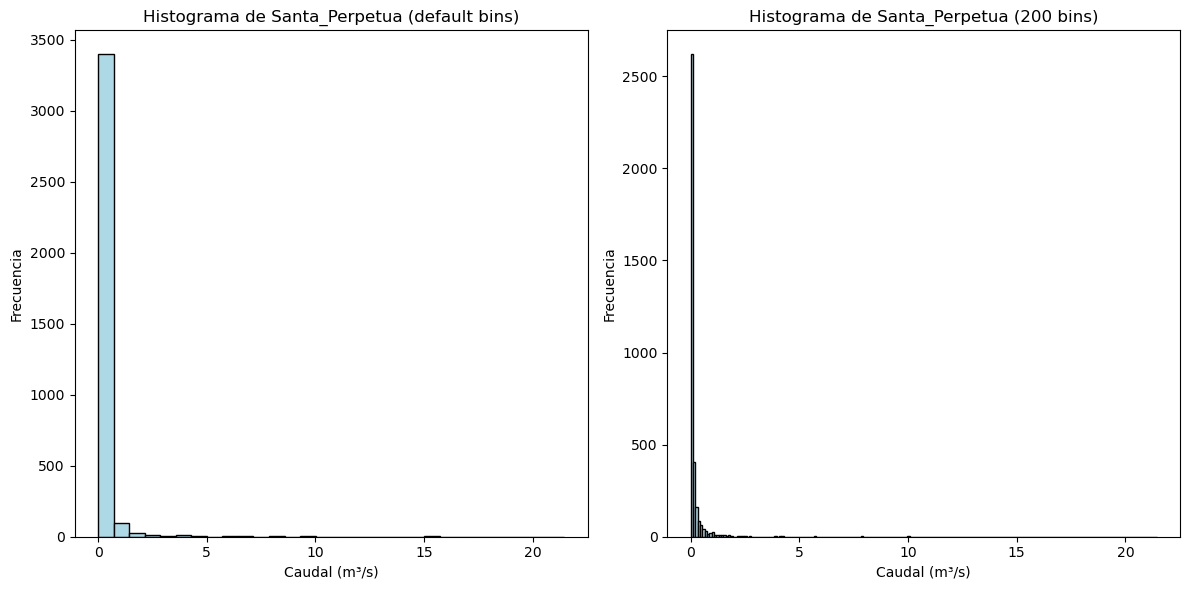

In [61]:
# Estacio
# Montcada_Reixac    3648
# Llica_de_Vall      3646
# Santa_Perpetua     3604
# Montornes          3047
# Santa_Coloma       2692
# Castellar          2577
# Aiguafreda         1493
# La_Garriga         1198

# 2. Seleccionar la estación
nombreST = "Santa_Perpetua"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Dibujar dos histogramas para observar la distribución de los datos
plt.figure(figsize=(12, 6))

# Subplot 1: Histograma con configuración predeterminada
plt.subplot(1, 2, 1)
plt.hist(DF_St['Valor'].dropna(), bins=30, color='lightblue', edgecolor='black')
plt.title(f"Histograma de {nombreST} (default bins)")
plt.xlabel("Caudal (m³/s)")
plt.ylabel("Frecuencia")

# Subplot 2: Histograma con 200 divisiones (bins)
plt.subplot(1, 2, 2)
plt.hist(DF_St['Valor'].dropna(), bins=200, color='lightblue', edgecolor='black')
plt.title(f"Histograma de {nombreST} (200 bins)")
plt.xlabel("Caudal (m³/s)")
plt.ylabel("Frecuencia")

# Ajustar el diseño para que los gráficos no se superpongan
plt.tight_layout()

# Mostrar los gráficos
plt.show()

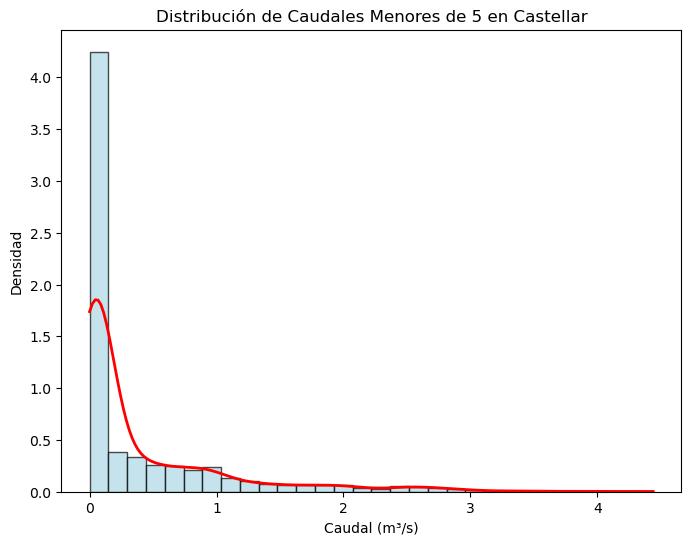

In [62]:
# 2. Seleccionar la estación
nombreST = "Castellar"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Recortar los valores menores a 5 y eliminar los NaNs
St1_nout = DF_St['Valor'][(DF_St['Valor'] < 5) & (DF_St['Valor'].notna())]

# 4. Dibujar el histograma y la curva de densidad
plt.figure(figsize=(8, 6))

# Histograma con probabilidad (densidad) en lugar de frecuencia
plt.hist(St1_nout, bins=30, density=True, color='lightblue', edgecolor='black', alpha=0.7)

# Calcular la curva de densidad utilizando gaussian_kde de scipy
density = gaussian_kde(St1_nout)
x_vals = np.linspace(min(St1_nout), max(St1_nout), 200)
density_vals = density(x_vals)

# Añadir la curva de densidad al histograma
plt.plot(x_vals, density_vals, color='red', lw=2)

# Añadir etiquetas y título
plt.title(f"Distribución de Caudales Menores de 5 en {nombreST}")
plt.xlabel("Caudal (m³/s)")
plt.ylabel("Densidad")

# Mostrar el gráfico
plt.show()

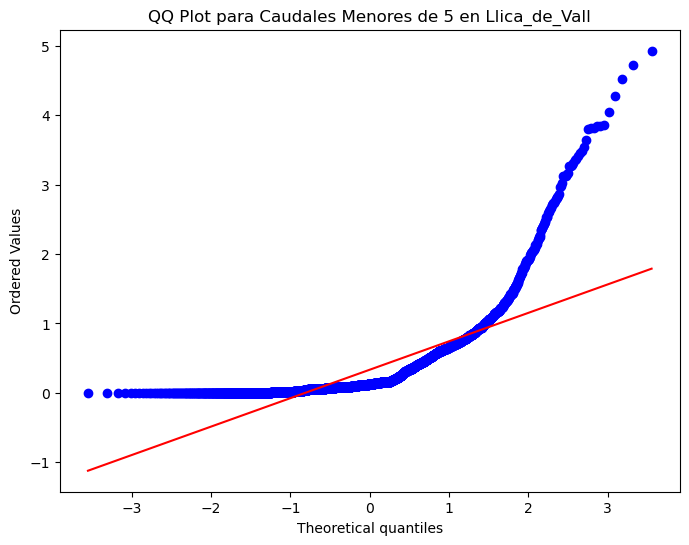

In [63]:
# 2. Seleccionar la estación
nombreST = "Llica_de_Vall"

# Crear un subconjunto con los datos de esa estación
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Recortar los valores menores a 5 y eliminar los NaNs
St1_nout = DF_St['Valor'][(DF_St['Valor'] < 5) & (DF_St['Valor'].notna())]

# 4. Crear el gráfico QQ plot para comprobar la normalidad
plt.figure(figsize=(8, 6))

# Graficar el QQ plot
stats.probplot(St1_nout, dist="norm", plot=plt)

# Añadir título
plt.title(f"QQ Plot para Caudales Menores de 5 en {nombreST}")

# Mostrar el gráfico
plt.show()

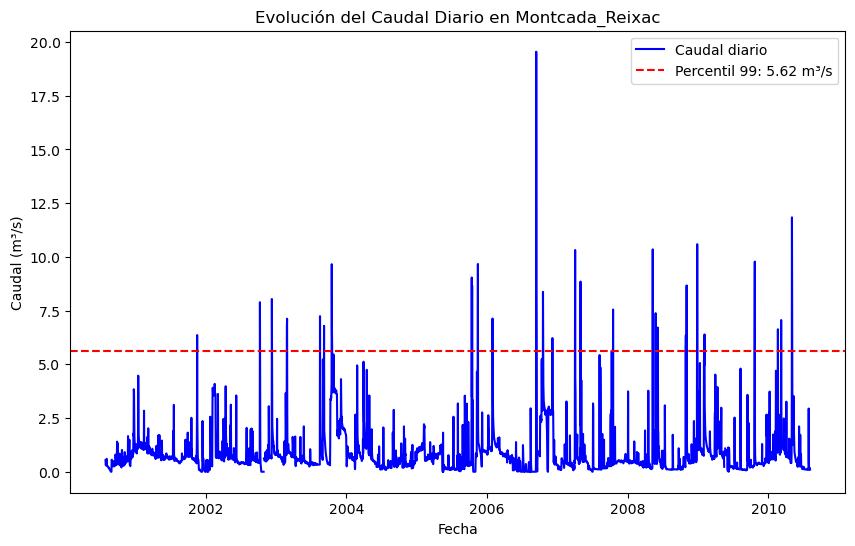

In [65]:
# 2. Seleccionar la estación "Montcada_Reixac"
nombreST = "Montcada_Reixac"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Ordenar los datos por fecha
DF_St = DF_St.sort_values(by='Fecha')

# 4. Dibujar el gráfico de la evolución del caudal diario
plt.figure(figsize=(10, 6))
plt.plot(DF_St['Fecha'], DF_St['Valor'], color='blue', linestyle='-', label='Caudal diario')

# 5. Calcular el percentil 99 del caudal
q99 = np.percentile(DF_St['Valor'].dropna(), 99)

# Añadir una línea horizontal en el percentil 99
plt.axhline(y=q99, color='red', linestyle='--', label=f'Percentil 99: {q99:.2f} m³/s')

# Añadir títulos y etiquetas
plt.title(f"Evolución del Caudal Diario en {nombreST}")
plt.xlabel("Fecha")
plt.ylabel("Caudal (m³/s)")

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

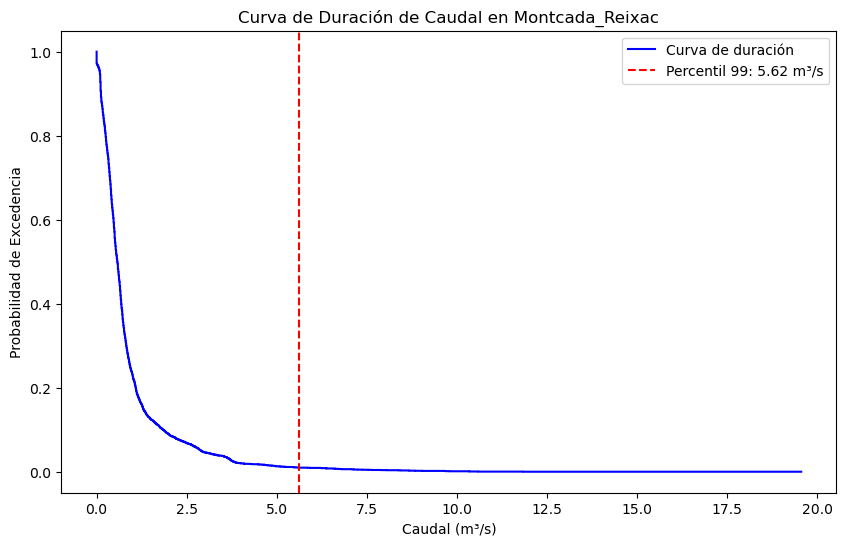

In [66]:
# 2. Seleccionar la estación "Montcada_Reixac"
nombreST = "Montcada_Reixac"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Eliminar los valores faltantes (NaN) en la columna 'Valor'
DF_St = DF_St.dropna(subset=['Valor'])

# 4. Ordenar los valores de caudal en orden descendente
sorted_caudal = DF_St['Valor'].sort_values(ascending=False).reset_index(drop=True)

# 5. Calcular la probabilidad de excedencia
n = len(sorted_caudal)
probabilidad_excedencia = np.arange(1, n+1) / n

# 6. Calcular el percentil 99 del caudal
q99 = np.percentile(sorted_caudal, 99)

# 7. Graficar la curva de duración de caudal
plt.figure(figsize=(10, 6))

# Gráfico de la curva de duración
plt.step(sorted_caudal, probabilidad_excedencia, where='post', color='blue', label='Curva de duración')

# Añadir una línea vertical en el percentil 99
plt.axvline(x=q99, color='red', linestyle='--', label=f'Percentil 99: {q99:.2f} m³/s')

# Añadir títulos y etiquetas
plt.title(f"Curva de Duración de Caudal en {nombreST}")
plt.xlabel("Caudal (m³/s)")
plt.ylabel("Probabilidad de Excedencia")

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

El periodo de retorno para un caudal de 10 m³/s es aproximadamente 727.60 días.


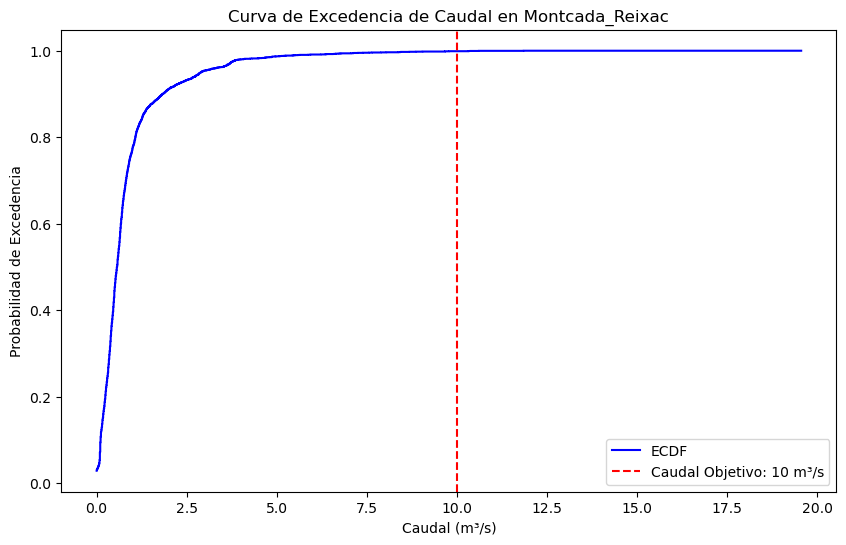

In [158]:
# 2. Seleccionar la estación "Montcada_Reixac"
nombreST = "Montcada_Reixac"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

# 3. Eliminar los valores faltantes (NaN) en la columna 'Valor'
DF_St = DF_St.dropna(subset=['Valor'])

# 4. Ordenar los valores de caudal en orden descendente
sorted_caudal = DF_St['Valor'].sort_values(ascending=False).reset_index(drop=True)

# 5. Crear la función ECDF usando statsmodels
ecdf = sm.distributions.ECDF(sorted_caudal)

# 6. Definir el caudal objetivo para el cual queremos calcular el periodo de retorno
caudal_objetivo = 10  # Caudal objetivo en m³/s

# 7. Calcular la probabilidad de excedencia para el caudal objetivo
# La probabilidad de excedencia es 1 - ECDF(caudal_objetivo)
probabilidad_excedencia_objetivo = 1 - ecdf(caudal_objetivo)

# 8. Calcular el periodo de retorno en días
if probabilidad_excedencia_objetivo > 0:
    periodo_retorno = 1 / probabilidad_excedencia_objetivo
else:
    periodo_retorno = np.inf  # Si no hay excedencia, el periodo de retorno es infinito

# Imprimir el periodo de retorno
print(f"El periodo de retorno para un caudal de {caudal_objetivo} m³/s es aproximadamente {periodo_retorno:.2f} días.")

# 9. Graficar la curva ECDF
plt.figure(figsize=(10, 6))
plt.step(sorted_caudal, ecdf(sorted_caudal), where='post', color='blue', label='ECDF')

# Añadir línea vertical para el caudal objetivo
plt.axvline(x=caudal_objetivo, color='red', linestyle='--', label=f'Caudal Objetivo: {caudal_objetivo} m³/s')

# Añadir títulos y etiquetas
plt.title(f"Curva de Excedencia de Caudal en {nombreST}")
plt.xlabel("Caudal (m³/s)")
plt.ylabel("Probabilidad de Excedencia")

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [159]:

# 1. Definir el caudal objetivo para el cual queremos calcular el periodo de retorno
caudal_objetivo = 12  # Caudal objetivo en m³/s

# 2. Obtener todas las estaciones únicas
estaciones_unicas = TotalDat['Estacio'].unique()

# 3. Crear un diccionario para almacenar los periodos de retorno por estación
resultados_periodo_retorno = {}

# 4. Iterar sobre cada estación para calcular el periodo de retorno
for nombreST in estaciones_unicas:
    # Filtrar los datos para la estación actual
    DF_St = TotalDat[TotalDat['Estacio'] == nombreST]

    # Eliminar los valores faltantes (NaN) en la columna 'Valor'
    DF_St = DF_St.dropna(subset=['Valor'])

    # Si no hay suficientes datos, continuar con la siguiente estación
    if DF_St.empty:
        print(f"No hay datos suficientes para la estación {nombreST}.")
        continue

    # Ordenar los valores de caudal en orden descendente
    sorted_caudal = DF_St['Valor'].sort_values(ascending=False).reset_index(drop=True)

    # Crear la función ECDF usando statsmodels
    ecdf = sm.distributions.ECDF(sorted_caudal)

    # Calcular la probabilidad de excedencia para el caudal objetivo
    probabilidad_excedencia_objetivo = 1 - ecdf(caudal_objetivo)

    # Calcular el periodo de retorno en días
    if probabilidad_excedencia_objetivo > 0:
        periodo_retorno = 1 / probabilidad_excedencia_objetivo
    else:
        periodo_retorno = np.inf  # Si no hay excedencia, el periodo de retorno es infinito

    # Guardar el resultado para la estación actual
    resultados_periodo_retorno[nombreST] = periodo_retorno

    # Imprimir el periodo de retorno para la estación actual
    print(f"El periodo de retorno para un caudal de {caudal_objetivo} m³/s en la estación {nombreST} es aproximadamente {periodo_retorno:.2f} días.")

# 5. Encontrar la estación con el mayor periodo de retorno
estacion_mayor_periodo = max(resultados_periodo_retorno, key=resultados_periodo_retorno.get)
mayor_periodo = resultados_periodo_retorno[estacion_mayor_periodo]

print(f"\nLa estación con el mayor periodo de retorno para caudales superiores a {caudal_objetivo} m³/s es {estacion_mayor_periodo}, con un periodo de retorno de {mayor_periodo:.2f} días.")


El periodo de retorno para un caudal de 12 m³/s en la estación Castellar es aproximadamente 316.50 días.
El periodo de retorno para un caudal de 12 m³/s en la estación Aiguafreda es aproximadamente 78.58 días.
El periodo de retorno para un caudal de 12 m³/s en la estación Montornes es aproximadamente 3047.00 días.
El periodo de retorno para un caudal de 12 m³/s en la estación Santa_Perpetua es aproximadamente 714.40 días.
El periodo de retorno para un caudal de 12 m³/s en la estación Santa_Coloma es aproximadamente 26.69 días.
El periodo de retorno para un caudal de 12 m³/s en la estación Llica_de_Vall es aproximadamente 1823.00 días.
El periodo de retorno para un caudal de 12 m³/s en la estación Montcada_Reixac es aproximadamente 3638.00 días.
El periodo de retorno para un caudal de 12 m³/s en la estación La_Garriga es aproximadamente inf días.

La estación con el mayor periodo de retorno para caudales superiores a 12 m³/s es La_Garriga, con un periodo de retorno de inf días.


In [68]:
import pandas as pd
import plotly.express as px

# Asegurarse de que la columna 'Fecha' es de tipo datetime
TotalDat['Fecha'] = pd.to_datetime(TotalDat['Fecha'])

# 1. Extraer el año y el mes de la columna 'Fecha'
TotalDat['Year'] = TotalDat['Fecha'].dt.year
TotalDat['Month'] = TotalDat['Fecha'].dt.month

# 2. Calcular el caudal medio mensual para cada estación por mes y año
caudal_medio_mensual = TotalDat.groupby(['Estacio', 'Year', 'Month']).agg({'Valor': 'mean'}).reset_index()

# 3. Crear una nueva columna 'YearMonth' para combinar el año y el mes
caudal_medio_mensual['YearMonth'] = pd.to_datetime(caudal_medio_mensual[['Year', 'Month']].assign(Day=1))

# 4. Crear el gráfico de barras interactivo con Plotly
fig = px.bar(caudal_medio_mensual, x='YearMonth', y='Valor', color='Estacio',
             title="Caudal Medio Mensual por Estación", 
             labels={"Valor": "Caudal Medio (m³/s)", "YearMonth": "Fecha", "Estacio": "Estación"},
             barmode='group',  # Puedes cambiar a 'stack' si prefieres barras apiladas
             text='Valor', hover_name="Estacio")

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Fecha",
    yaxis_title="Caudal Medio Mensual (m³/s)",
    legend_title="Estaciones",
    bargap=0.15,  # Espacio entre las barras
    hovermode="x unified"
)

# Mostrar el gráfico interactivo
fig.show()



In [69]:
import pandas as pd
import plotly.express as px

# 1. Seleccionar una estación específica
nombreST = "Llica_de_Vall"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST].copy()  # Usar .copy() para evitar la advertencia

# 2. Extraer el año y el mes de la columna 'Fecha'
DF_St.loc[:, 'Year'] = DF_St['Fecha'].dt.year  # Usar .loc[] para evitar la advertencia
DF_St.loc[:, 'Month'] = DF_St['Fecha'].dt.month

# 3. Calcular el caudal medio mensual para esa estación por mes y año
caudal_medio_mensual = DF_St.groupby(['Year', 'Month']).agg({'Valor': 'mean'}).reset_index()

# 4. Crear una nueva columna 'YearMonth' para combinar el año y el mes
caudal_medio_mensual['YearMonth'] = pd.to_datetime(caudal_medio_mensual[['Year', 'Month']].assign(Day=1))

# 5. Crear el gráfico de líneas interactivo con Plotly para la estación seleccionada
fig = px.line(caudal_medio_mensual, x='YearMonth', y='Valor', 
              title=f"Evolución del Caudal Medio Mensual en {nombreST}", 
              labels={"Valor": "Caudal Medio Mensual (m³/s)", "YearMonth": "Fecha"},
              #text='Valor'
              )

# 6. Ajustar el diseño del gráfico para mostrar los valores con mayor precisión
fig.update_layout(
    yaxis=dict(tickformat=".4f"),  # Ajustar la precisión del eje Y
    xaxis_title="Fecha",
    yaxis_title="Caudal Medio Mensual (m³/s)",
    hovermode="x unified"
)

# 7. Mostrar el gráfico interactivo
fig.show()


In [166]:

# 1. Asegurarse de que la columna 'Year' y 'Month' estén creadas
TotalDat['Year'] = TotalDat['Fecha'].dt.year  # Extraer el año
TotalDat['Month'] = TotalDat['Fecha'].dt.month  # Extraer el mes

# 2. Calcular el caudal medio mensual para todas las estaciones por mes y año
caudal_medio_mensual_todas = TotalDat.groupby(['Estacio', 'Year', 'Month']).agg({'Valor': 'mean'}).reset_index()

# 3. Crear una nueva columna 'YearMonth' para combinar el año y el mes
caudal_medio_mensual_todas['YearMonth'] = pd.to_datetime(caudal_medio_mensual_todas[['Year', 'Month']].assign(Day=1))

# 4. Crear el gráfico de líneas interactivo con Plotly para todas las estaciones
fig = px.line(caudal_medio_mensual_todas, x='YearMonth', y='Valor', color='Estacio',
              title="Evolución del Caudal Medio Mensual por Estación",
              labels={"Valor": "Caudal Medio Mensual (m³/s)", "YearMonth": "Fecha", "Estacio": "Estación"})

# 5. Ajustar el diseño del gráfico para mostrar los valores con mayor precisión
fig.update_layout(
    yaxis=dict(tickformat=".4f"),  # Ajustar la precisión del eje Y
    xaxis_title="Fecha",
    yaxis_title="Caudal Medio Mensual (m³/s)",
    hovermode="x unified"
)

# 6. Mostrar el gráfico interactivo
fig.show()



In [165]:

# 1. Asegurarse de que la columna 'Year' y 'Month' estén creadas
TotalDat['Year'] = TotalDat['Fecha'].dt.year  # Extraer el año
TotalDat['Month'] = TotalDat['Fecha'].dt.month  # Extraer el mes

# 2. Calcular el caudal medio mensual para todas las estaciones por mes y año
caudal_medio_mensual_todas = TotalDat.groupby(['Estacio', 'Year', 'Month']).agg({'Valor': 'mean'}).reset_index()

# 3. Crear una nueva columna 'YearMonth' para combinar el año y el mes
caudal_medio_mensual_todas['YearMonth'] = pd.to_datetime(caudal_medio_mensual_todas[['Year', 'Month']].assign(Day=1))

# 4. Obtener la lista de estaciones únicas
estaciones_unicas = caudal_medio_mensual_todas['Estacio'].unique()

# 5. Generar gráficos de líneas separados para cada estación
for estacion in estaciones_unicas:
    # Filtrar los datos para la estación actual
    datos_estacion = caudal_medio_mensual_todas[caudal_medio_mensual_todas['Estacio'] == estacion]
    
    # Crear el gráfico de líneas para la estación actual
    fig = px.line(datos_estacion, x='YearMonth', y='Valor',
                  title=f"Evolución del Caudal Medio Mensual en {estacion}",
                  labels={"Valor": "Caudal Medio Mensual (m³/s)", "YearMonth": "Fecha"})
    
    # Ajustar el diseño del gráfico
    fig.update_layout(
        yaxis=dict(tickformat=".4f"),  # Ajustar la precisión del eje Y
        xaxis_title="Fecha",
        yaxis_title="Caudal Medio Mensual (m³/s)",
        hovermode="x unified"
    )
    
    # Mostrar el gráfico interactivo
    fig.show()


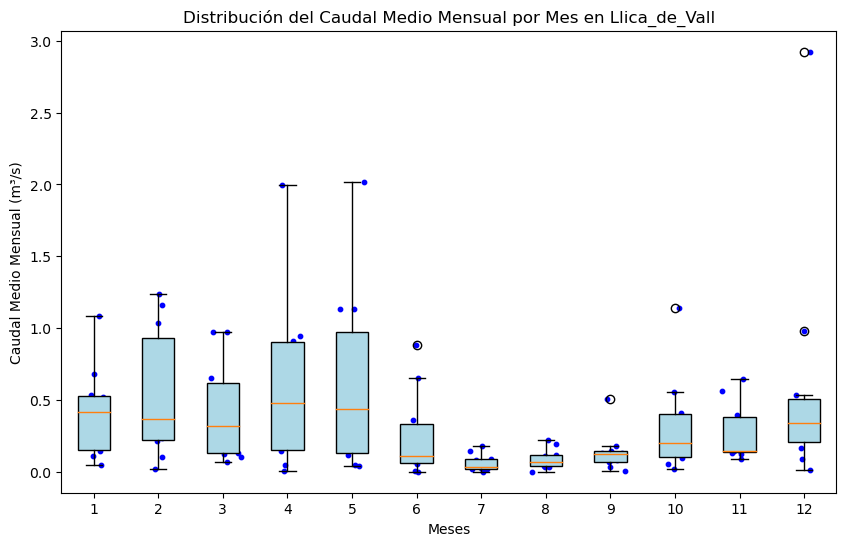

In [70]:
# 1. Seleccionar la estación específica
nombreST = "Llica_de_Vall"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST].copy()

# 2. Extraer el año y el mes de la columna 'Fecha'
DF_St['Year'] = DF_St['Fecha'].dt.year
DF_St['Month'] = DF_St['Fecha'].dt.month

# 3. Calcular el caudal medio mensual para esa estación por mes y año
caudal_medio_mensual = DF_St.groupby(['Year', 'Month']).agg({'Valor': 'mean'}).reset_index()

# 4. Crear el diagrama de cajas (boxplot) para analizar la distribución de los caudales medios mensuales
plt.figure(figsize=(10, 6))

# Crear el boxplot de caudal medio mensual por mes
plt.boxplot([caudal_medio_mensual[caudal_medio_mensual['Month'] == m]['Valor'] for m in range(1, 13)],
            patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Añadir etiquetas y título
plt.xlabel("Meses")
plt.ylabel("Caudal Medio Mensual (m³/s)")
plt.title("Distribución del Caudal Medio Mensual por Mes en Llica_de_Vall")

# 5. Dibujar puntos desplazados (con jitter) para los valores del caudal medio mensual
jitter_positions = np.random.normal(caudal_medio_mensual['Month'], 0.1)  # Añadir jitter al mes
plt.scatter(jitter_positions, caudal_medio_mensual['Valor'], color='blue', s=10, label='Caudal Medio Mensual')

# Mostrar el gráfico
plt.show()

In [71]:
# Verifica cuántos datos faltantes hay por mes
print(caudal_medio_mensual.isna().sum())

# Revisa cuántos datos hay por cada mes
print(caudal_medio_mensual['Mes'].value_counts())

# Eliminar filas con valores NaN en 'Valor'
caudal_medio_mensual = caudal_medio_mensual.dropna(subset=['Valor'])

# Filtrar para solo meses con suficientes datos
caudal_medio_mensual = caudal_medio_mensual[caudal_medio_mensual['Mes'].isin([1, 7, 8])]




# 1. Seleccionar la estación específica
nombreST = "Llica_de_Vall"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST].copy()

# 2. Extraer el mes de la columna 'Fecha'
DF_St['Mes'] = DF_St['Fecha'].dt.month

# 3. Calcular el caudal medio mensual
caudal_medio_mensual = DF_St.groupby(['Mes', 'Year']).agg({'Valor': 'mean'}).reset_index()

# 4. Aplicar ANOVA para comparar caudales entre meses
model = ols('Valor ~ C(Mes)', data=caudal_medio_mensual).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# 5. Preparar subconjuntos de datos para Julio, Agosto y Enero
agosto_data = caudal_medio_mensual[caudal_medio_mensual['Mes'] == 8]
julio_data = caudal_medio_mensual[caudal_medio_mensual['Mes'] == 7]
enero_data = caudal_medio_mensual[caudal_medio_mensual['Mes'] == 1]

# 6. Prueba t para comparar Julio y Agosto
t_test_MesesVerano = stats.ttest_ind(julio_data['Valor'], agosto_data['Valor'], equal_var=False)
print("Prueba t para Julio y Agosto (meses de verano):")
print(t_test_MesesVerano)

# 7. Prueba t para comparar Julio y Enero (verano e invierno)
t_test_Verano_Inv = stats.ttest_ind(julio_data['Valor'], enero_data['Valor'], equal_var=False)
print("Prueba t para Julio y Enero (verano e invierno):")
print(t_test_Verano_Inv)

# 8. Repetir ANOVA solo para Enero, Julio y Agosto
tresMeses = pd.concat([agosto_data, julio_data, enero_data])
model2 = ols('Valor ~ C(Mes)', data=tresMeses).fit()
anova_table2 = sm.stats.anova_lm(model2, typ=2)
print(anova_table2)

Year     0
Month    0
Valor    0
dtype: int64


KeyError: 'Mes'

In [318]:
# 1. Seleccionar la estación específica
nombreST = "Llica_de_Vall"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST].copy()

# 2. Extraer el mes y el año de la columna 'Fecha'
DF_St['Mes'] = DF_St['Fecha'].dt.month
DF_St['Year'] = DF_St['Fecha'].dt.year

# 3. Calcular el caudal medio mensual agrupado por Mes y Año
caudal_medio_anual = DF_St.groupby(['Mes', 'Year']).agg({'Valor': 'mean'}).reset_index()

# 4. Crear el gráfico de líneas interactivo con Plotly
fig = px.line(caudal_medio_anual, x='Mes', y='Valor', color='Year', 
              title="Evolución del Caudal Medio Mensual por Año",
              labels={'Mes': 'Mes', 'Valor': 'Caudal Medio (m³/s)', 'Year': 'Año'})

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title="Mes",
    yaxis_title="Caudal Medio (m³/s)",
    legend_title="Año",
    hovermode="x unified"
)

# Mostrar el gráfico interactivo
fig.show()

In [319]:
# 1. Calcular la desviación estándar por estación y mes
sd_Estaciones_mes = TotalDat.groupby(['Estacio', 'Mes']).agg({'Valor': 'std'}).reset_index()

# 2. Calcular el coeficiente de variación (CV) por estación y mes
cv = TotalDat.groupby(['Estacio', 'Mes']).agg(
    {'Valor': lambda x: np.std(x) / np.mean(x)}
).reset_index()

# 3. Crear el gráfico interactivo del coeficiente de variación por estación y mes
fig = px.line(cv, x='Mes', y='Valor', color='Estacio',
              title="Evolución Mensual del Coeficiente de Variación por Estación",
              labels={'Mes': 'Mes', 'Valor': 'Coeficiente de Variación', 'Estacio': 'Estación'})

# Personalizar el gráfico
fig.update_layout(
    xaxis=dict(tickvals=list(range(1, 13)), ticktext=[str(i) for i in range(1, 13)]),  # Meses en el eje X
    xaxis_title="Mes",
    yaxis_title="Coeficiente de Variación",
    hovermode="x unified",
    legend_title="Estaciones"
)

# Mostrar el gráfico interactivo
fig.show()

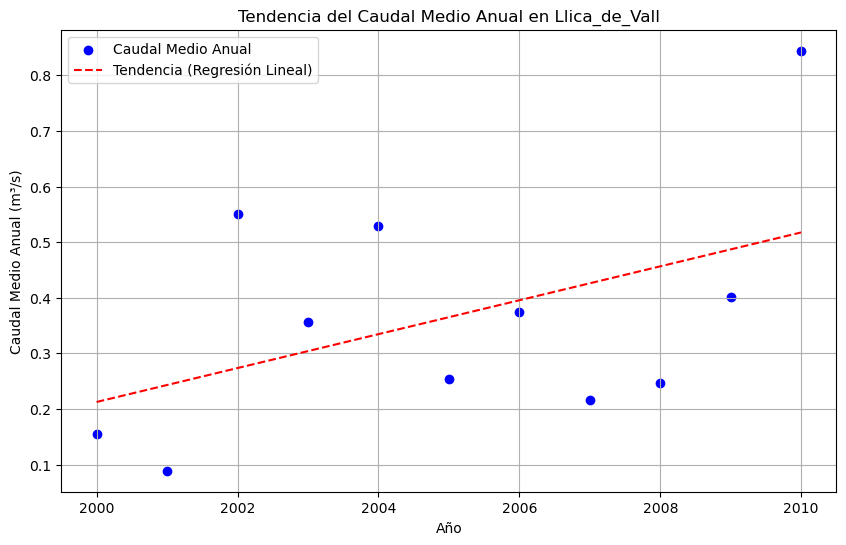

Pendiente (slope) de la regresión: 0.030479503553271305
Intersección (intercept) con el eje Y: -60.74634549521687


In [344]:
####5.5 Tendencia de los caudales a lo largo del tiempo.

## 1. Seleccionar una estación específica
nombreST = "Llica_de_Vall"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST].copy()

# 2. Extraer el año de la columna 'Fecha'
DF_St['Year'] = DF_St['Fecha'].dt.year

# 3. Calcular el caudal medio anual para la estación
caudal_medio_anual = DF_St.groupby('Year').agg({'Valor': 'mean'}).reset_index()

# 4. Realizar una regresión lineal para analizar la tendencia
X = caudal_medio_anual['Year'].values.reshape(-1, 1)  # Variable independiente (años)
y = caudal_medio_anual['Valor'].values  # Variable dependiente (caudal medio)

# Ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# 5. Predecir valores usando el modelo de regresión
y_pred = model.predict(X)

# 6. Visualizar la tendencia de los caudales a lo largo del tiempo
plt.figure(figsize=(10, 6))
plt.scatter(caudal_medio_anual['Year'], caudal_medio_anual['Valor'], color='blue', label='Caudal Medio Anual')
plt.plot(caudal_medio_anual['Year'], y_pred, color='red', linestyle='--', label='Tendencia (Regresión Lineal)')
plt.title(f"Tendencia del Caudal Medio Anual en {nombreST}")
plt.xlabel('Año')
plt.ylabel('Caudal Medio Anual (m³/s)')
plt.legend()
plt.grid(True)
plt.show()

# 7. Mostrar los coeficientes de la regresión lineal
slope = model.coef_[0]
intercept = model.intercept_
print(f"Pendiente (slope) de la regresión: {slope}")
print(f"Intersección (intercept) con el eje Y: {intercept}")

Pendiente (Estimate): 5.196371761126476e-05
Intersección (Intercept): -37.68856375008256
R^2: 0.006344723509186911


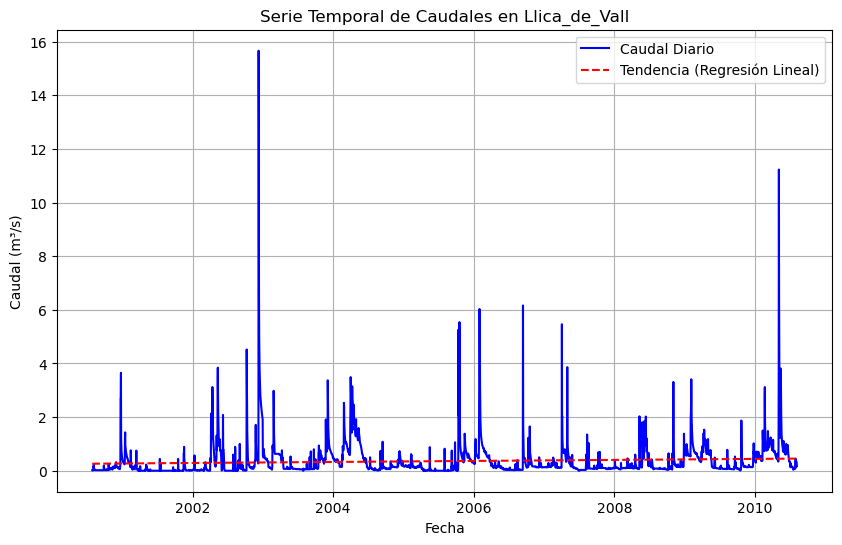

Pendiente de la recta de regresión: 0.0000519637


In [345]:
#5.5.1 Analsisis de TENDENCIAS a partir de los caudales medios Diarios

# 1. Seleccionar una estación específica
nombreST = "Llica_de_Vall"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST].copy()

# 2. Convertir la columna 'Fecha' a números para realizar la regresión
DF_St['Fecha_num'] = DF_St['Fecha'].map(pd.Timestamp.toordinal)  # Convertir las fechas a números

# 3. Realizar la regresión lineal (caudal ~ fecha)
X = DF_St['Fecha_num'].values.reshape(-1, 1)  # Variable independiente (Fecha como número)
y = DF_St['Valor'].values  # Variable dependiente (Caudal)

# Ajustar el modelo de regresión lineal
modelo_tendencia = LinearRegression()
modelo_tendencia.fit(X, y)

# 4. Obtener los coeficientes de la regresión
pendiente = modelo_tendencia.coef_[0]
intercepto = modelo_tendencia.intercept_

# 5. Mostrar el resumen del modelo
print(f"Pendiente (Estimate): {pendiente}")
print(f"Intersección (Intercept): {intercepto}")
print(f"R^2: {modelo_tendencia.score(X, y)}")

# 6. Predecir los valores con la recta de regresión
y_pred = modelo_tendencia.predict(X)

# 7. Graficar la serie temporal de caudales con la tendencia
plt.figure(figsize=(10, 6))
plt.plot(DF_St['Fecha'], DF_St['Valor'], color='blue', label='Caudal Diario')
plt.plot(DF_St['Fecha'], y_pred, color='red', linestyle='--', label='Tendencia (Regresión Lineal)')
plt.title(f"Serie Temporal de Caudales en {nombreST}")
plt.xlabel('Fecha')
plt.ylabel('Caudal (m³/s)')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar la pendiente de la regresión
print(f"Pendiente de la recta de regresión: {pendiente:.10f}")

In [348]:
#5.5.2 Analsisis de tendencias a partir de los caudales mensuales

# 1. Seleccionar una estación específica
nombreST = "Llica_de_Vall"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST].copy()  # Usar .copy() para evitar la advertencia

# 2. Extraer el año y el mes de la columna 'Fecha'
DF_St.loc[:, 'Year'] = DF_St['Fecha'].dt.year  # Usar .loc[] para evitar la advertencia
DF_St.loc[:, 'Month'] = DF_St['Fecha'].dt.month

# 3. Calcular el caudal medio mensual para esa estación por mes y año
caudal_medio_mensual = DF_St.groupby(['Year', 'Month']).agg({'Valor': 'mean'}).reset_index()

# 4. Crear una nueva columna 'YearMonth' para combinar el año y el mes
caudal_medio_mensual['YearMonth'] = pd.to_datetime(caudal_medio_mensual[['Year', 'Month']].assign(Day=1))

# 5. Realizar la regresión lineal
# Convertir YearMonth a números ordinales para el modelo de regresión
caudal_medio_mensual['YearMonth_num'] = caudal_medio_mensual['YearMonth'].map(pd.Timestamp.toordinal)

# Variables para la regresión
X = caudal_medio_mensual['YearMonth_num'].values.reshape(-1, 1)  # Variable independiente (fecha numérica)
y = caudal_medio_mensual['Valor'].values  # Variable dependiente (caudal medio mensual)

# Ajustar el modelo de regresión lineal
modelo_tendencia = LinearRegression()
modelo_tendencia.fit(X, y)

# Predecir los valores con la recta de regresión
y_pred = modelo_tendencia.predict(X)

# 6. Crear el gráfico de líneas interactivo con Plotly para la estación seleccionada
fig = px.line(caudal_medio_mensual, x='YearMonth', y='Valor', 
              title=f"Evolución del Caudal Medio Mensual en {nombreST} con Tendencia", 
              labels={"Valor": "Caudal Medio Mensual (m³/s)", "YearMonth": "Fecha"})

# 7. Añadir la línea de tendencia predicha por la regresión lineal
fig.add_scatter(x=caudal_medio_mensual['YearMonth'], y=y_pred, mode='lines', name='Tendencia (Regresión Lineal)', line=dict(color='red', dash='dash'))

# 8. Ajustar el diseño del gráfico para mostrar los valores con mayor precisión
fig.update_layout(
    yaxis=dict(tickformat=".4f"),  # Ajustar la precisión del eje Y
    xaxis_title="Fecha",
    yaxis_title="Caudal Medio Mensual (m³/s)",
    hovermode="x unified"
)

# 9. Mostrar el gráfico interactivo
fig.show()

# 10. Imprimir los coeficientes de la regresión
pendiente = modelo_tendencia.coef_[0]
intercepto = modelo_tendencia.intercept_
print(f"Pendiente: {pendiente:.10f}")
print(f"Intercepto: {intercepto:.4f}")
print(f"R^2: {modelo_tendencia.score(X, y):.4f}")

Pendiente: 0.0000538925
Intercepto: -39.1026
R^2: 0.0165


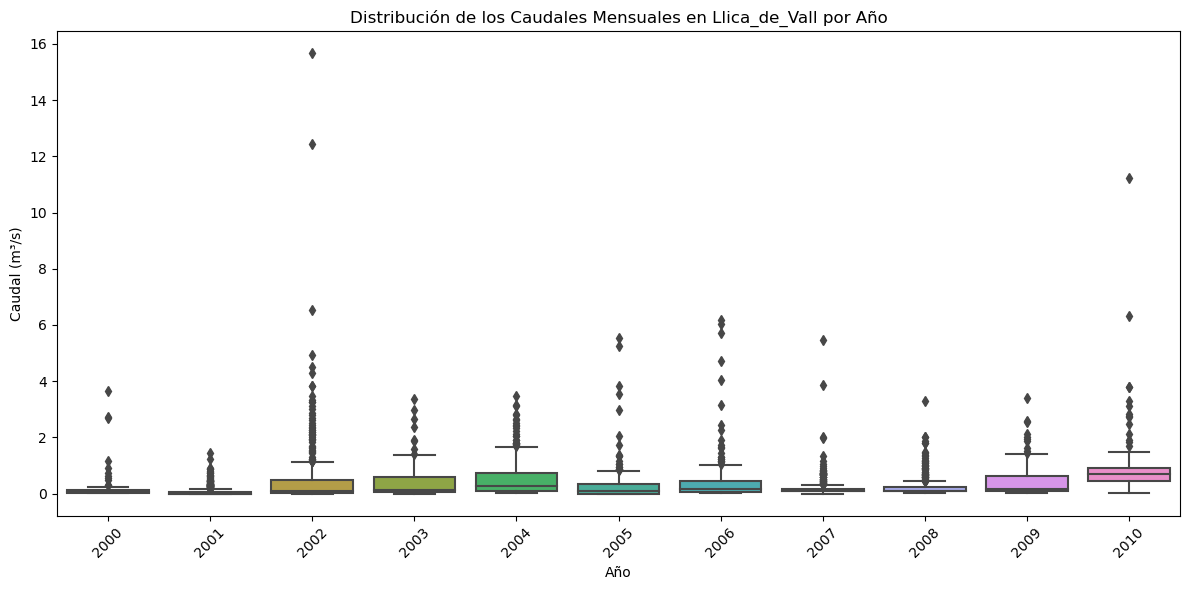

In [349]:
# 1. Seleccionar una estación específica
nombreST = "Llica_de_Vall"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST].copy()

# 2. Extraer el año de la columna 'Fecha'
DF_St['Year'] = DF_St['Fecha'].dt.year

# 3. Generar el diagrama de cajas (boxplot) con la distribución de los caudales mensuales por año
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Valor', data=DF_St)

# 4. Añadir títulos y etiquetas
plt.title(f"Distribución de los Caudales Mensuales en {nombreST} por Año")
plt.xlabel("Año")
plt.ylabel("Caudal (m³/s)")

# 5. Mostrar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X si hay muchos años
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()

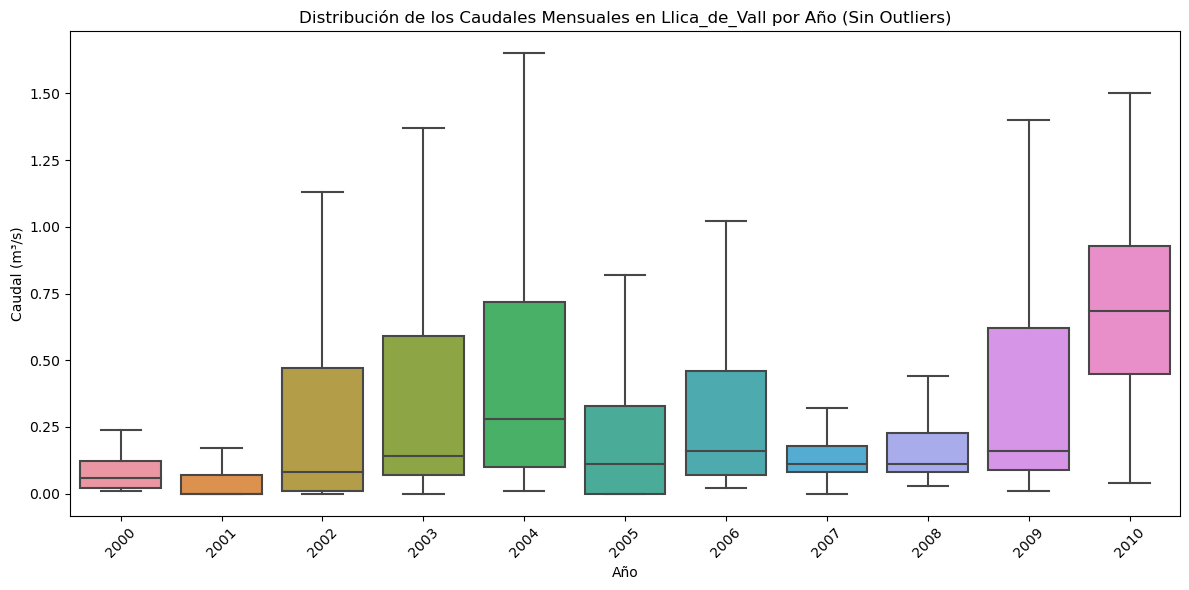

In [350]:
# 1. Seleccionar una estación específica
nombreST = "Llica_de_Vall"
DF_St = TotalDat[TotalDat['Estacio'] == nombreST].copy()

# 2. Extraer el año de la columna 'Fecha'
DF_St['Year'] = DF_St['Fecha'].dt.year

# 3. Generar el diagrama de cajas (boxplot) sin valores atípicos (outliers)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Valor', data=DF_St, showfliers=False)  # showfliers=False elimina los outliers

# 4. Añadir títulos y etiquetas
plt.title(f"Distribución de los Caudales Mensuales en {nombreST} por Año (Sin Outliers)")
plt.xlabel("Año")
plt.ylabel("Caudal (m³/s)")

# 5. Mostrar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X si hay muchos años
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()

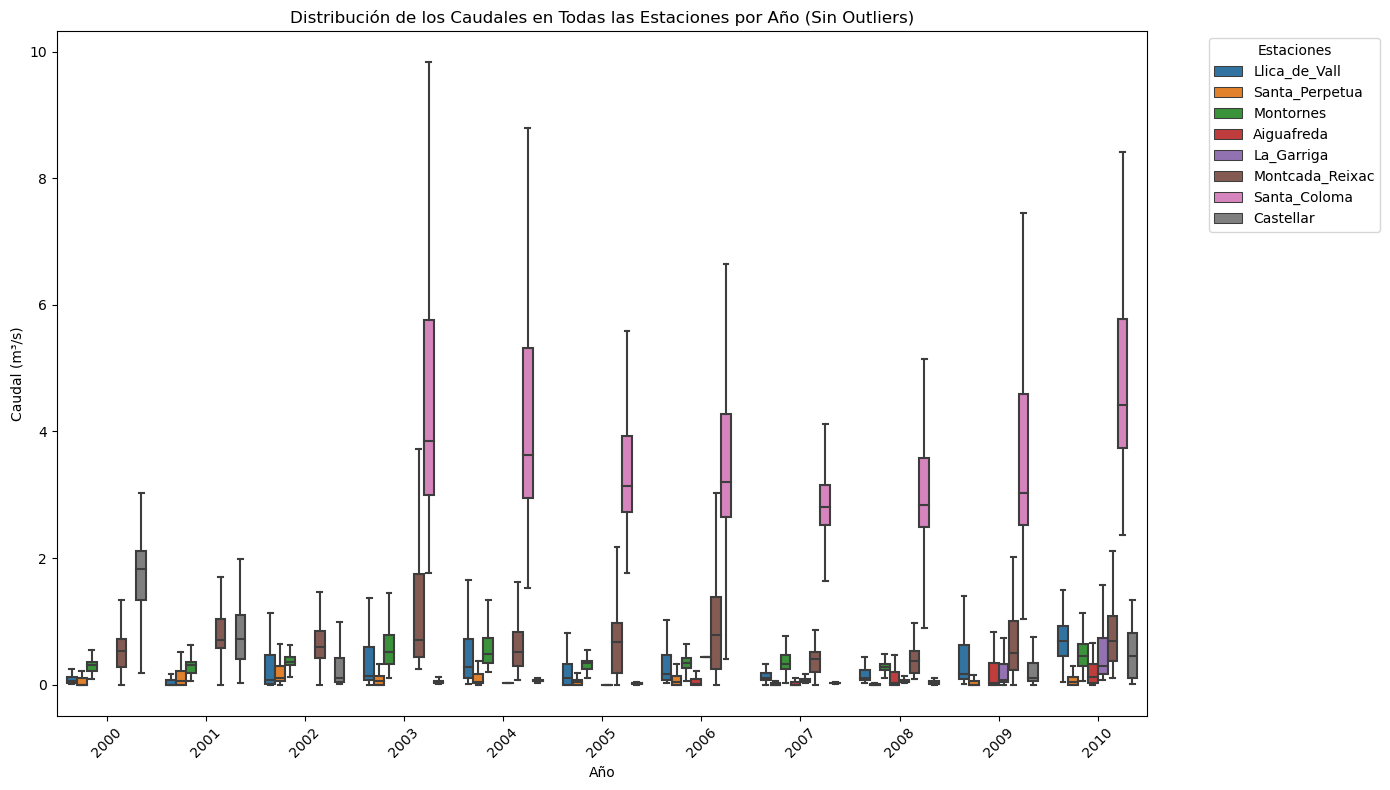

In [168]:
# 1. Asegurarse de que la columna 'Year' esté creada
TotalDat['Year'] = TotalDat['Fecha'].dt.year  # Extraer el año

# 2. Generar el diagrama de cajas (boxplot) para todas las estaciones, sin outliers
plt.figure(figsize=(14, 8))
sns.boxplot(x='Year', y='Valor', hue='Estacio', data=TotalDat, showfliers=False)  # showfliers=False elimina los outliers

# 3. Añadir títulos y etiquetas
plt.title("Distribución de los Caudales en Todas las Estaciones por Año (Sin Outliers)")
plt.xlabel("Año")
plt.ylabel("Caudal (m³/s)")

# 4. Mostrar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X si hay muchos años
plt.legend(title='Estaciones', bbox_to_anchor=(1.05, 1), loc='upper left')  # Colocar la leyenda fuera del gráfico
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()


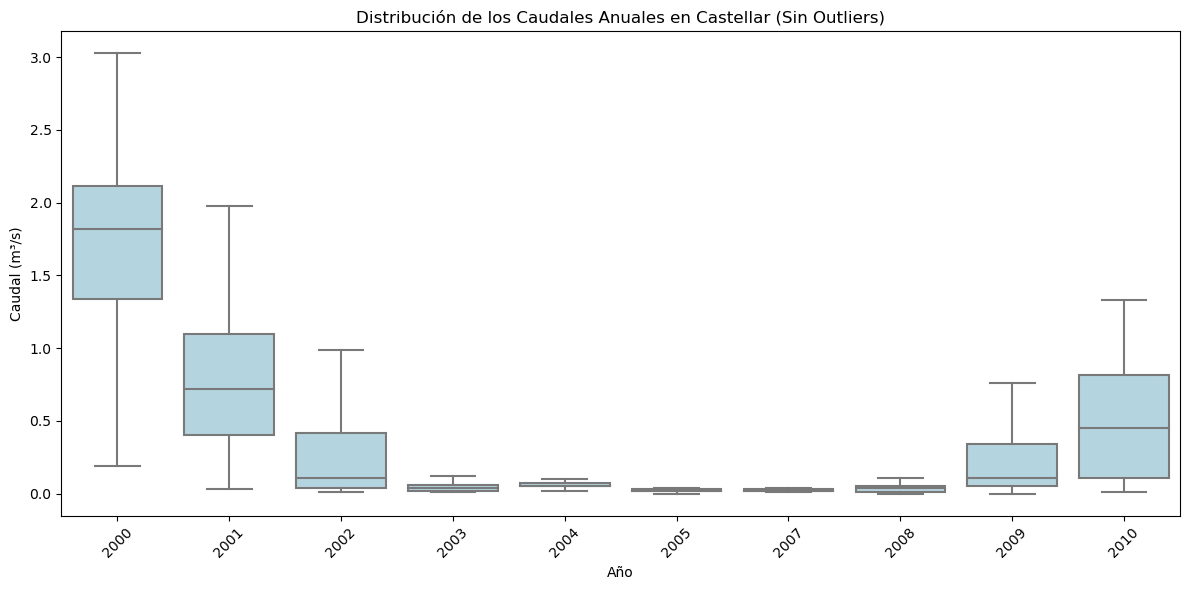

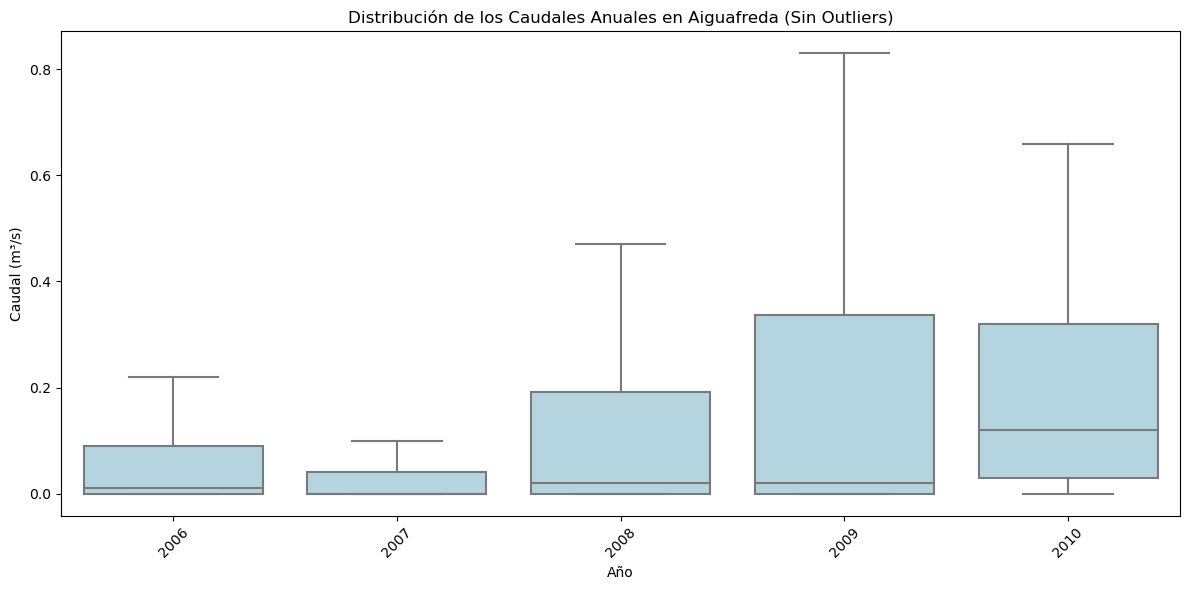

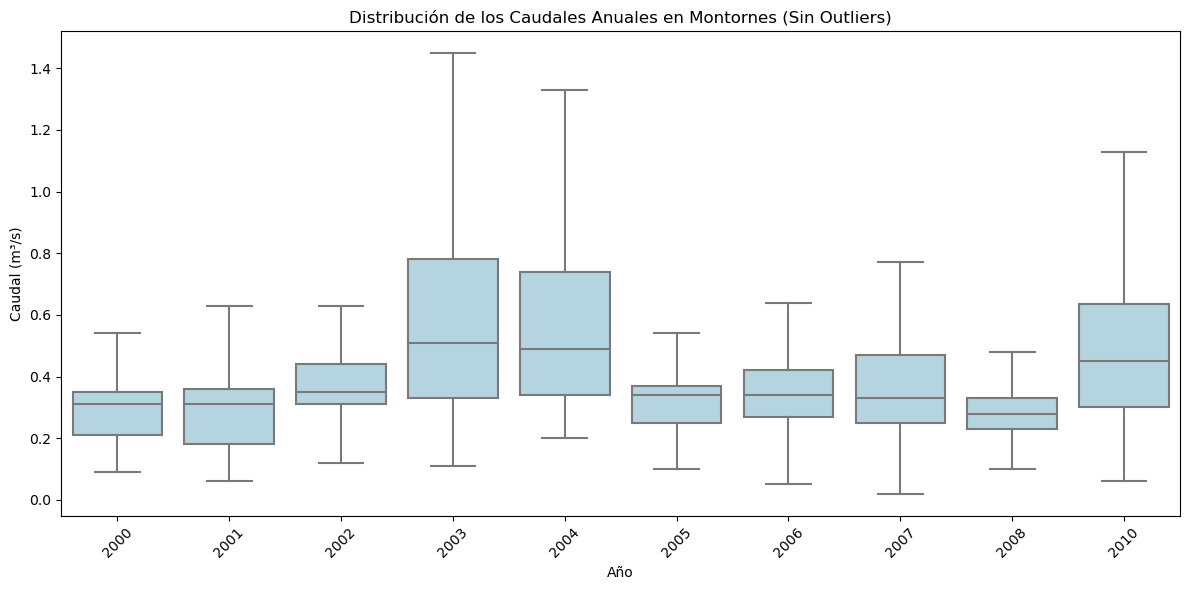

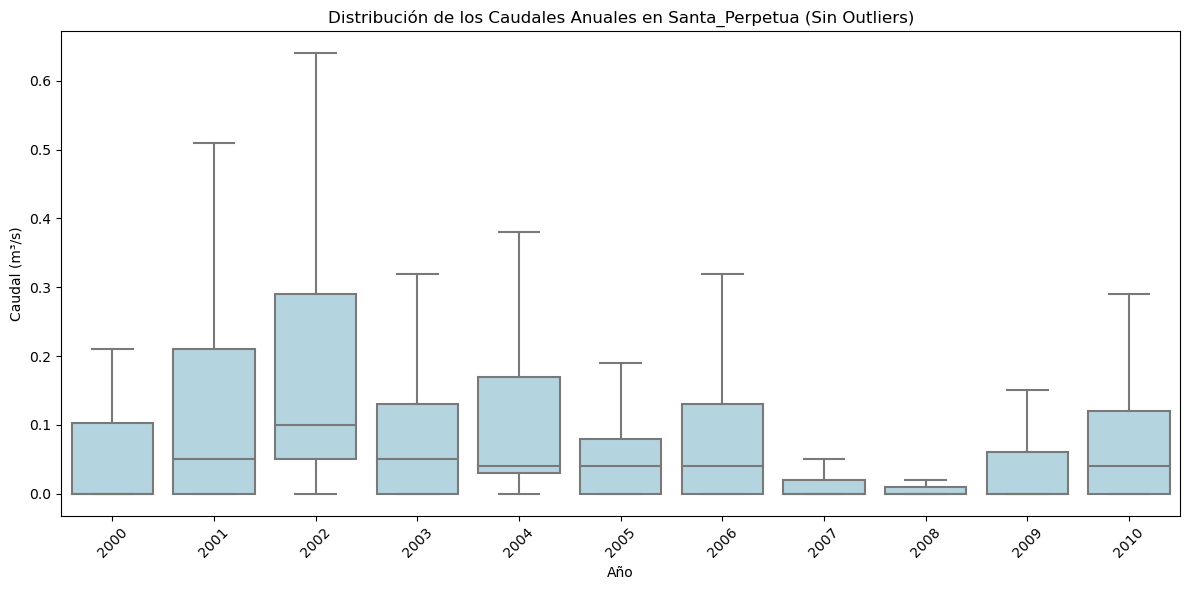

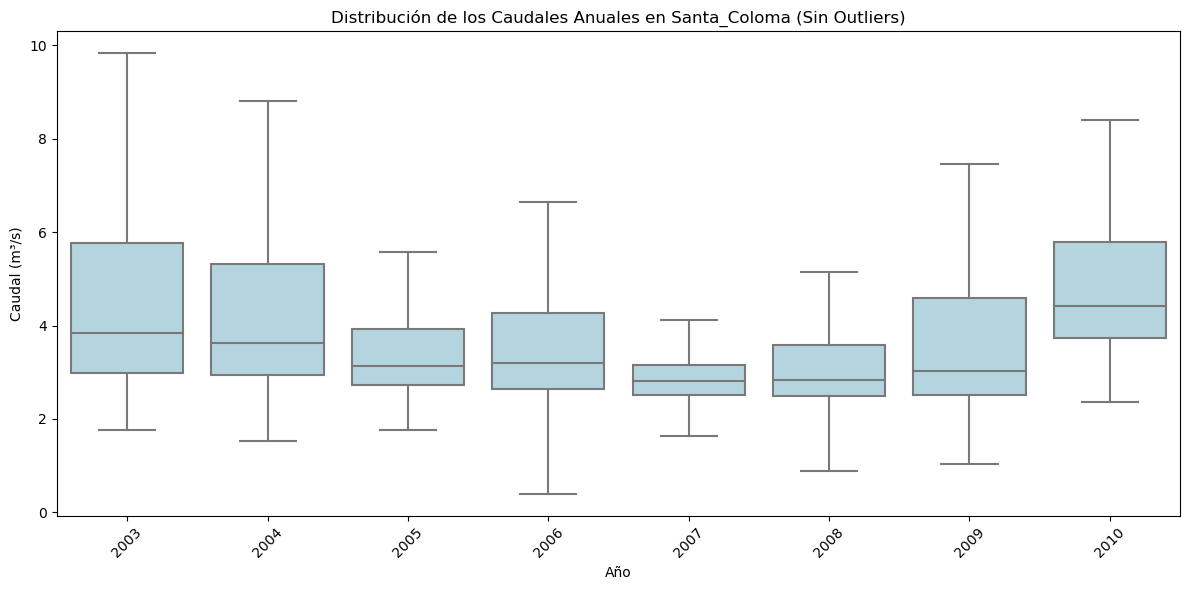

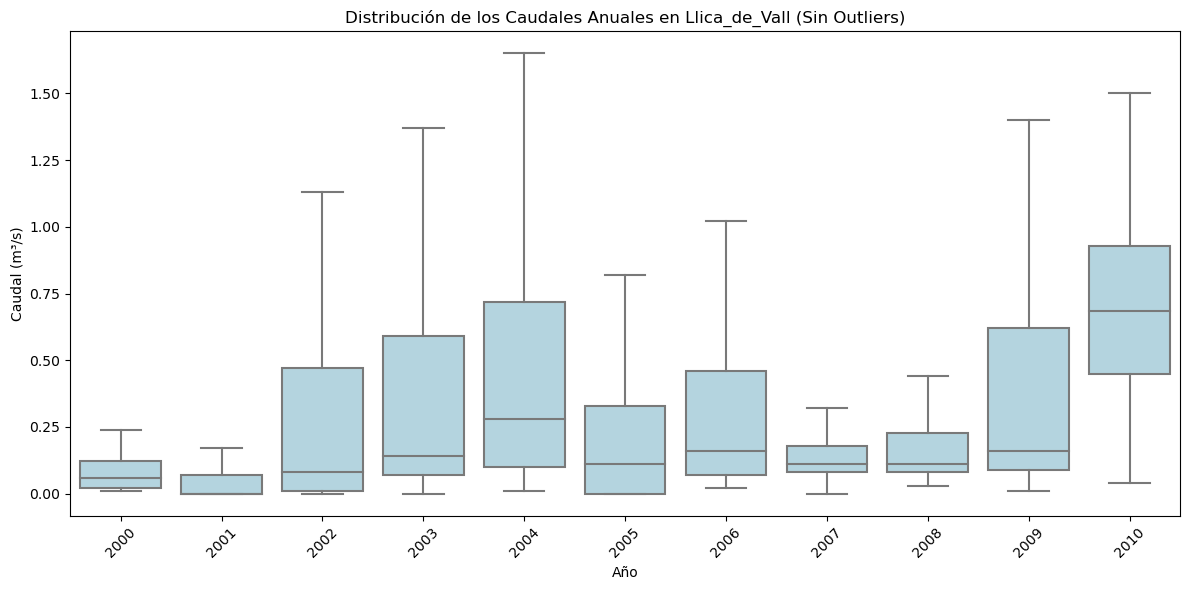

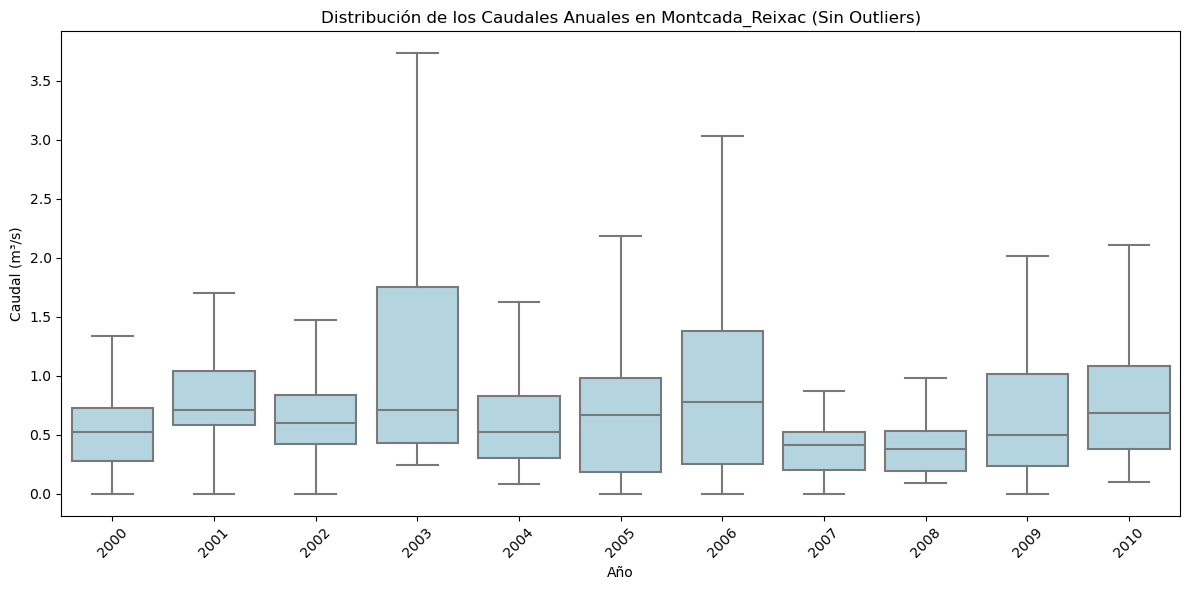

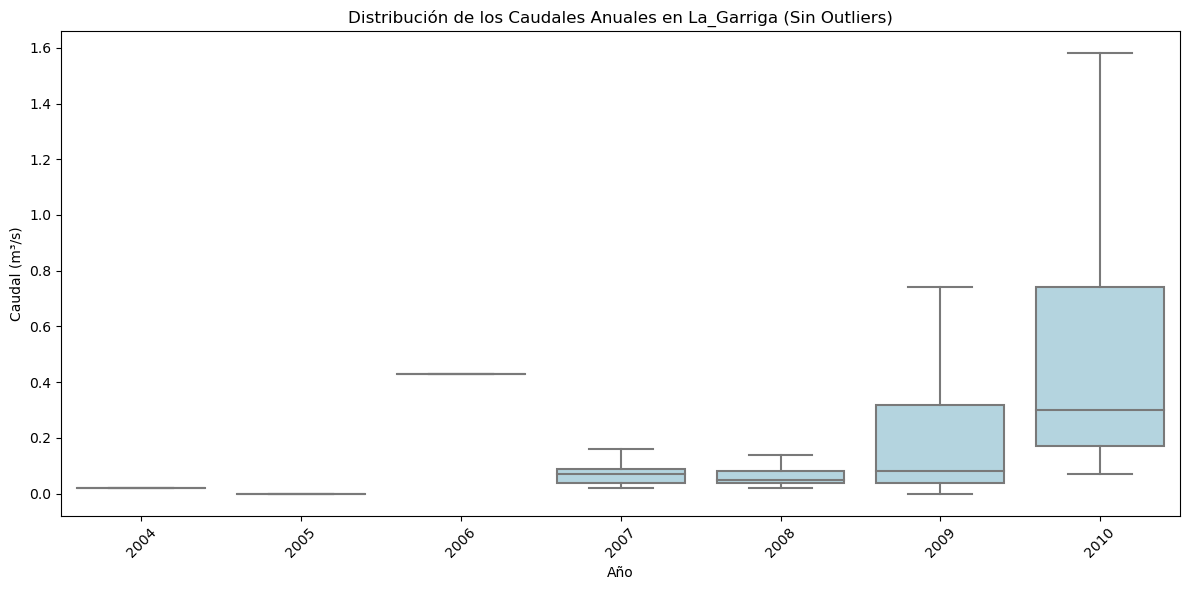

In [170]:

# Asegurarse de que la columna 'Year' esté creada a partir de la columna 'Fecha'
TotalDat['Year'] = TotalDat['Fecha'].dt.year

# Obtener las estaciones únicas
estaciones_unicas = TotalDat['Estacio'].unique()

# Crear gráficos separados para cada estación
for estacion in estaciones_unicas:
    # Filtrar los datos para cada estación
    DF_St = TotalDat[TotalDat['Estacio'] == estacion]
    
    # Crear un nuevo gráfico para cada estación
    plt.figure(figsize=(12, 6))
    
    # Generar el boxplot sin outliers
    sns.boxplot(x='Year', y='Valor', data=DF_St, showfliers=False, color="lightblue")
    
    # Añadir títulos y etiquetas
    plt.title(f"Distribución de los Caudales Anuales en {estacion} (Sin Outliers)")
    plt.xlabel("Año")
    plt.ylabel("Caudal (m³/s)")
    
    # Ajustes adicionales
    plt.xticks(rotation=45)  # Rotar las etiquetas del eje X si es necesario
    plt.tight_layout()  # Para ajustar el gráfico
    
    # Mostrar el gráfico
    plt.show()


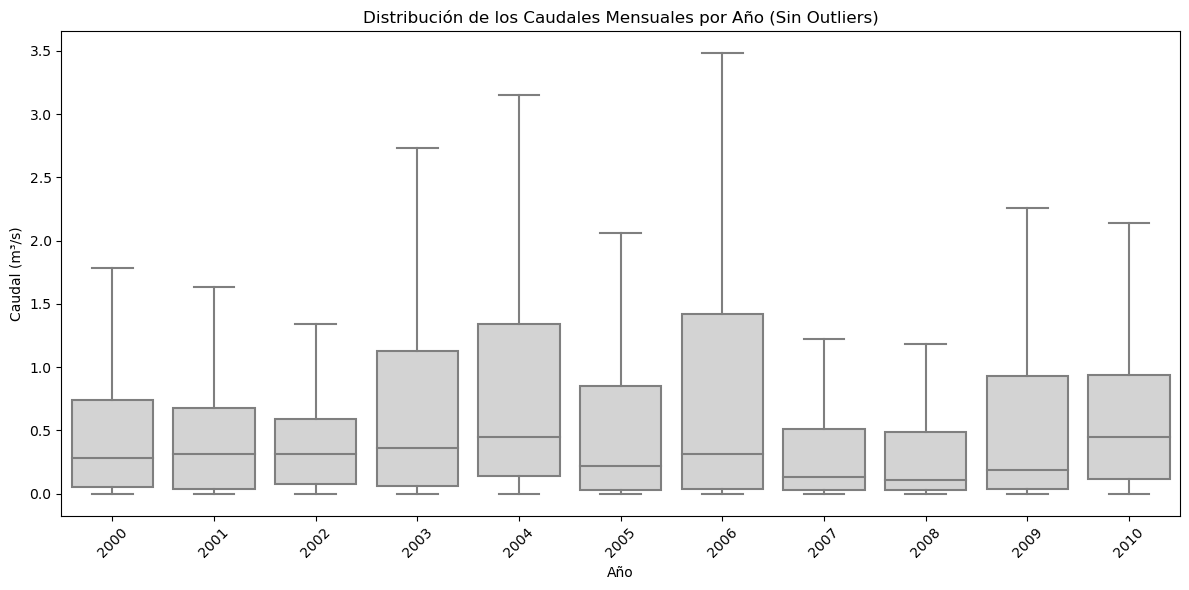

In [169]:

# 1. Asegurarse de que la columna 'Year' esté creada a partir de la columna 'Fecha'
TotalDat['Year'] = TotalDat['Fecha'].dt.year

# 2. Crear el diagrama de cajas (boxplot) para mostrar la distribución de los caudales agregados por año
plt.figure(figsize=(12, 6))

# Diagrama de cajas sin outliers
sns.boxplot(x='Year', y='Valor', data=TotalDat, showfliers=False, color="lightgray")

# 3. Añadir títulos y etiquetas
plt.title("Distribución de los Caudales Mensuales por Año (Sin Outliers)")
plt.xlabel("Año")
plt.ylabel("Caudal (m³/s)")

# 4. Ajustes adicionales
plt.xticks(rotation=45)  # Rotar las etiquetas de los años si es necesario
plt.tight_layout()  # Para ajustar el gráfico y evitar que se superpongan los elementos

# 5. Mostrar el gráfico
plt.show()


Datos disponibles simultáneamente: 923


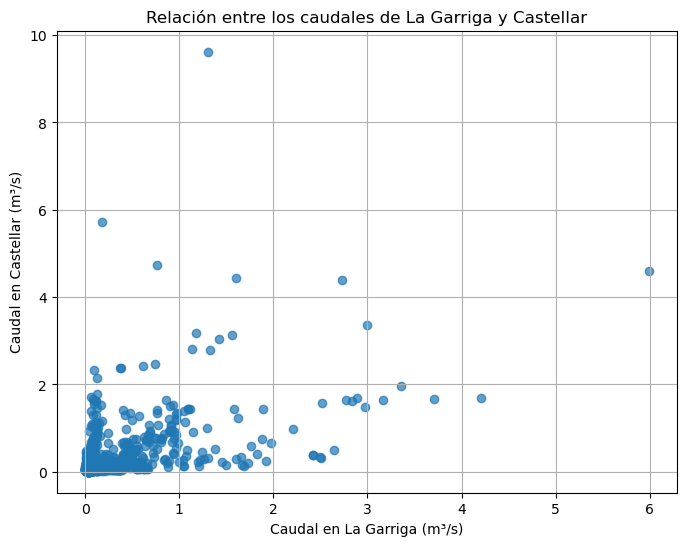

Correlación entre los caudales de La Garriga y Castellar:
           LaGarriga  Castellar
LaGarriga   1.000000   0.514097
Castellar   0.514097   1.000000


In [351]:
#6 Correlacion entre los caudales varias estaciones

# 1. Seleccionar dos estaciones específicas
nombreST1 = "Castellar"
nombreST2 = "La_Garriga"  # Asegúrate de que el nombre coincida con el usado en el dataframe

# 2. Filtrar los datos para las dos estaciones seleccionadas
DF_dosST = TotalDat[TotalDat['Estacio'].isin([nombreST1, nombreST2])].copy()

# 3. Reorganizar los datos para tener una columna por estación, asegurando que coincidan las fechas
DF_dosST_pivot = DF_dosST.pivot_table(index='Fecha', columns='Estacio', values='Valor', aggfunc='mean').reset_index()

# 4. Eliminar filas donde alguna estación no tiene datos
DF_dosST_pivot_clean = DF_dosST_pivot.dropna(subset=[nombreST1, nombreST2])

# 5. Renombrar las columnas para mayor claridad
DF_dosST_pivot_clean.columns = ['Fecha', 'Castellar', 'LaGarriga']

# 6. Mostrar el número de filas donde ambas estaciones tienen datos
print(f"Datos disponibles simultáneamente: {DF_dosST_pivot_clean.shape[0]}")

# 7. Dibujar gráfico de dispersión entre los caudales de las dos estaciones
plt.figure(figsize=(8, 6))
plt.scatter(DF_dosST_pivot_clean['LaGarriga'], DF_dosST_pivot_clean['Castellar'], alpha=0.7)
plt.title("Relación entre los caudales de La Garriga y Castellar")
plt.xlabel("Caudal en La Garriga (m³/s)")
plt.ylabel("Caudal en Castellar (m³/s)")
plt.grid(True)
plt.show()

# 8. Calcular la correlación entre los caudales de las dos estaciones
correlacion = DF_dosST_pivot_clean[['LaGarriga', 'Castellar']].corr()
print("Correlación entre los caudales de La Garriga y Castellar:")
print(correlacion)

Correlación entre Castellar y La_Garriga: 0.514097


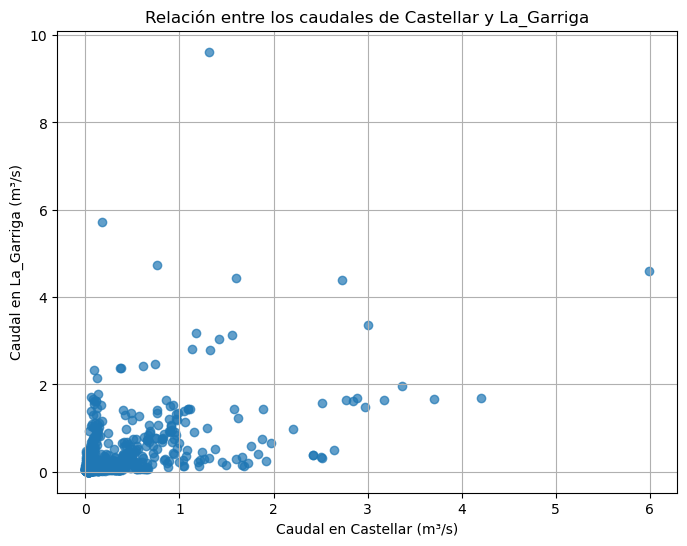

Matriz de correlación entre las estaciones:
Estacio          Llica_de_Vall  Santa_Perpetua  Montornes  Aiguafreda  \
Estacio                                                                 
Llica_de_Vall             1.00            0.73       0.80        0.35   
Santa_Perpetua            0.73            1.00       0.79        0.47   
Montornes                 0.80            0.79       1.00        0.41   
Aiguafreda                0.35            0.47       0.41        1.00   
La_Garriga                0.90            0.69       0.72        0.37   
Montcada_Reixac           0.63            0.92       0.70        0.45   
Santa_Coloma              0.85            0.92       0.88        0.50   
Castellar                 0.81            0.55       0.65        0.18   

Estacio          La_Garriga  Montcada_Reixac  Santa_Coloma  Castellar  
Estacio                                                                
Llica_de_Vall          0.90             0.63          0.85       0.81  
Santa_Per

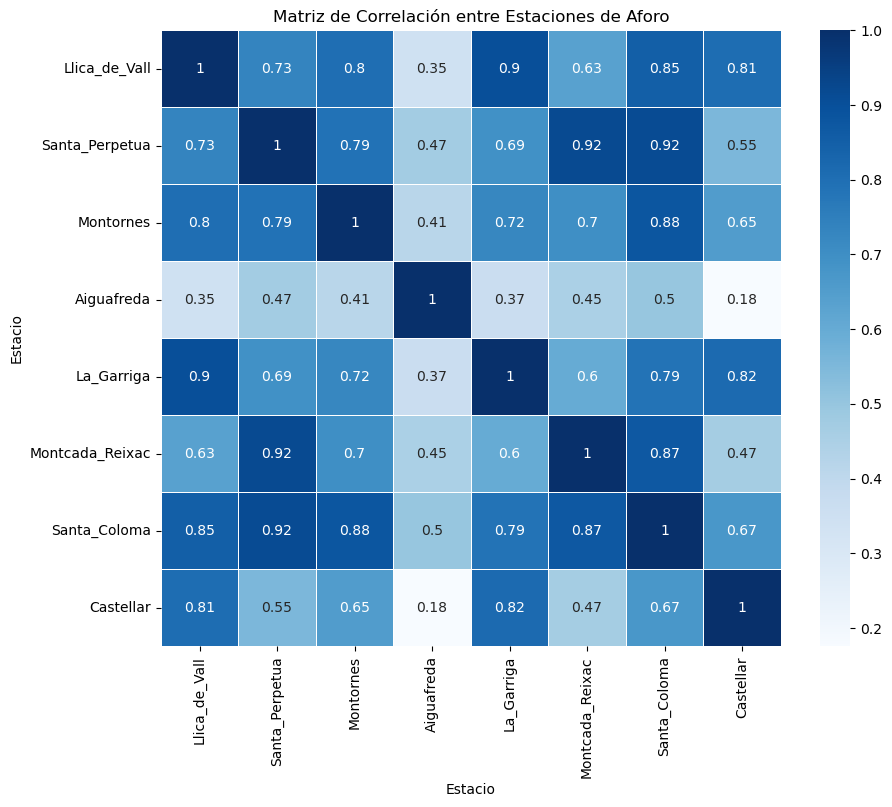

In [47]:

# 1. Seleccionar dos estaciones específicas
nombreST1 = "Castellar"
nombreST2 = "La_Garriga"

# 2. Filtrar los datos para las dos estaciones seleccionadas
DF_dosST = TotalDat[TotalDat['Estacio'].isin([nombreST1, nombreST2])].copy()

# 3. Reorganizar los datos para tener una columna por estación con las mismas fechas
DF_dosST_pivot = DF_dosST.pivot_table(index='Fecha', columns='Estacio', values='Valor', aggfunc='mean').reset_index()

# 4. Eliminar filas donde alguna estación no tiene datos
DF_dosST_pivot_clean = DF_dosST_pivot.dropna(subset=[nombreST1, nombreST2])

# 5. Calcular la correlación entre los caudales de las dos estaciones
correlation = DF_dosST_pivot_clean[[nombreST1, nombreST2]].corr().iloc[0, 1]
print(f"Correlación entre {nombreST1} y {nombreST2}: {correlation:.6f}")

# 6. Visualizar el gráfico de dispersión entre los caudales de ambas estaciones
plt.figure(figsize=(8, 6))
plt.scatter(DF_dosST_pivot_clean[nombreST1], DF_dosST_pivot_clean[nombreST2], alpha=0.7)
plt.title(f"Relación entre los caudales de {nombreST1} y {nombreST2}")
plt.xlabel(f"Caudal en {nombreST1} (m³/s)")
plt.ylabel(f"Caudal en {nombreST2} (m³/s)")
plt.grid(True)
plt.show()

# 7. Reorganizar los datos para todas las estaciones (excluyendo 'Fecha')
data_casted = TotalDat.pivot_table(index='Fecha', columns='Estacio', values='Valor', aggfunc='mean').reset_index()

# 8. Eliminar filas con valores faltantes (NaN)
data_casted_clean = data_casted.dropna()

# 9. Calcular la matriz de correlación entre todas las estaciones, excluyendo la columna 'Fecha'
correlation_matrix = data_casted_clean.drop(columns='Fecha').corr()

# 10. Imprimir la matriz de correlación
print("Matriz de correlación entre las estaciones:")
print(correlation_matrix.round(2))

# 11. Visualización de la matriz de correlación usando un mapa de calor (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5)
plt.title("Matriz de Correlación entre Estaciones de Aforo")
plt.show()